# Seasonal range of tracer concentrations, T, S, age


In [36]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
from cosima_cookbook import explore

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.path as mpath
from matplotlib import ticker, cm
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
import glob,os
import climtas.nci
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmcrameri
import gsw
import climtas.nci



import cartopy.crs as ccrs
import cartopy.feature as cfeature

import sys
sys.path.append("/g/data/x77/ps7863/python_scripts")
import helper_functions as helper

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)


from dask.distributed import Client

figdir = '/g/data/x77/ps7863/figures/AABW_variability/'

In [2]:
climtas.nci.GadiClient()

<Client: 'tcp://127.0.0.1:35381' processes=12 threads=12, memory=46.00 GiB>

In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
expt = '01deg_jra55v140_iaf_cycle3_antarctic_tracers'

In [4]:
lon_slice = slice(80-360, 190-360)
lat_slice = slice(-82, -55)

degree =  u'\N{DEGREE SIGN}'

In [5]:
ht = cc.querying.getvar(iaf_cycle3,'ht',session, n=1) 
ht = ht.sel(yt_ocean = lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

In [6]:
shelf_mask = ht > 1000
shelf_mask = shelf_mask.astype(bool)
masked_shelf = shelf_mask.where(shelf_mask==0, np.nan)
shelf_mask = shelf_mask.where(shelf_mask==1, np.nan)
shelf_mask

<xarray.DataArray 'ht' (yt_ocean: 584, xt_ocean: 1100)> Size: 5MB
dask.array<where, shape=(584, 1100), dtype=float64, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 9kB -279.9 -279.8 -279.7 ... -170.1 -170.0
  * yt_ocean  (yt_ocean) float64 5kB -81.11 -81.07 -81.02 ... -55.07 -55.01

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [8]:
land_50m = cfeature.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="black", facecolor="grey", linewidth=0.5
)

In [9]:
xt_ocean = ht.xt_ocean
yt_ocean = ht.yt_ocean

In [10]:
X, Y = np.meshgrid(xt_ocean, yt_ocean)
X = xr.DataArray(X, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])
Y = xr.DataArray(Y, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])

In [11]:
def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """

    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(
        boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[1, ::-1], latitudes[1, ::-1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[:, 1], latitudes[:, 1]]), axis=1
    )
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

In [12]:
# To plot 1000-m contour
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf[np.where(shelf!=0)] = np.nan
shelf = shelf+1
shelf = np.nan_to_num(shelf)
shelf = xr.DataArray(shelf, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

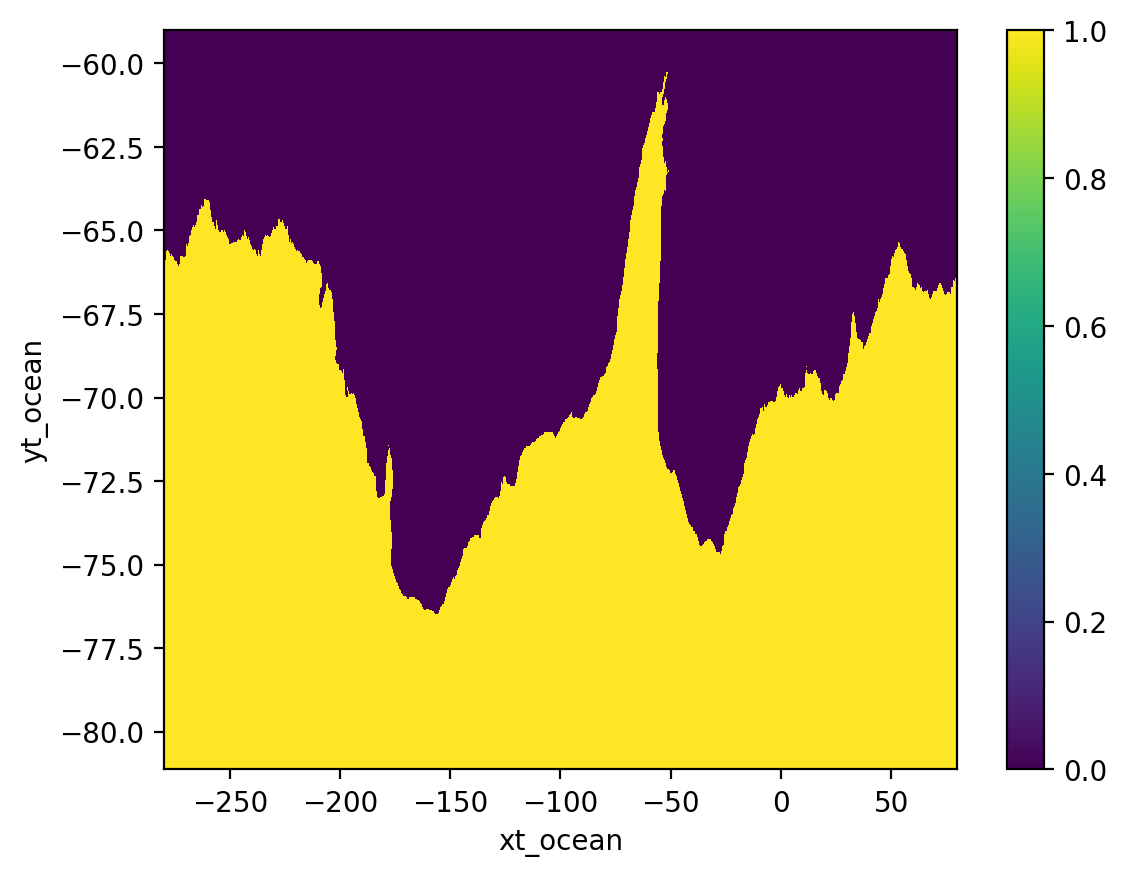

In [8]:
shelf.plot()

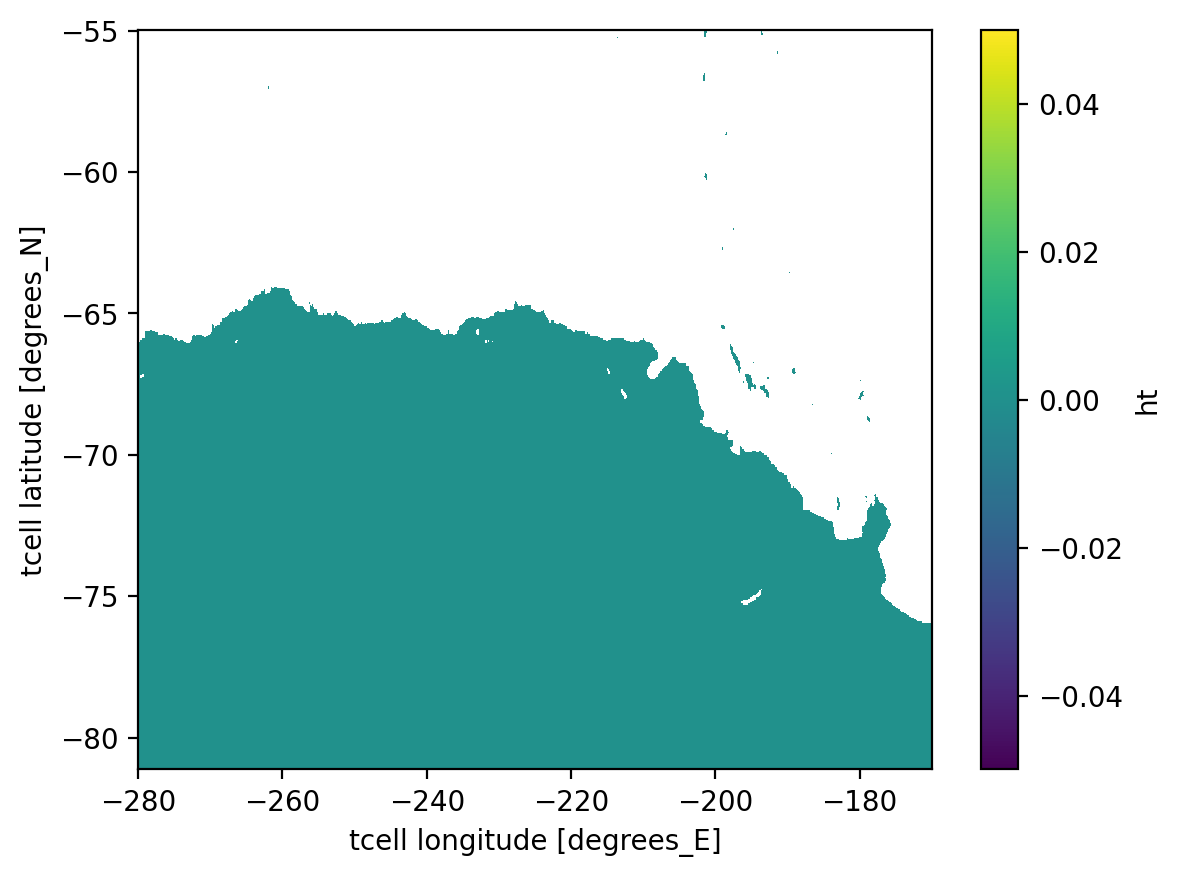

In [63]:
masked_shelf.plot()

In [13]:
first_year = 1990
last_year = 2018
start_time = f'01-01-{first_year}'
end_time = f'31-12-{last_year}'
time_slice = slice(start_time, end_time)

# Tracer concentrations

In [14]:
albw = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/ALBW_tracer_bottom_500_1958-2018.nc')
rsbw = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/RSBW_tracer_bottom_500_1958-2018.nc')
albw = albw['ALBW_tracer']
rsbw = rsbw['RSBW tracer']

In [15]:
albw = albw.sel(time=time_slice)
rsbw = rsbw.sel(time=time_slice)

NameError: name 'albw_clim' is not defined

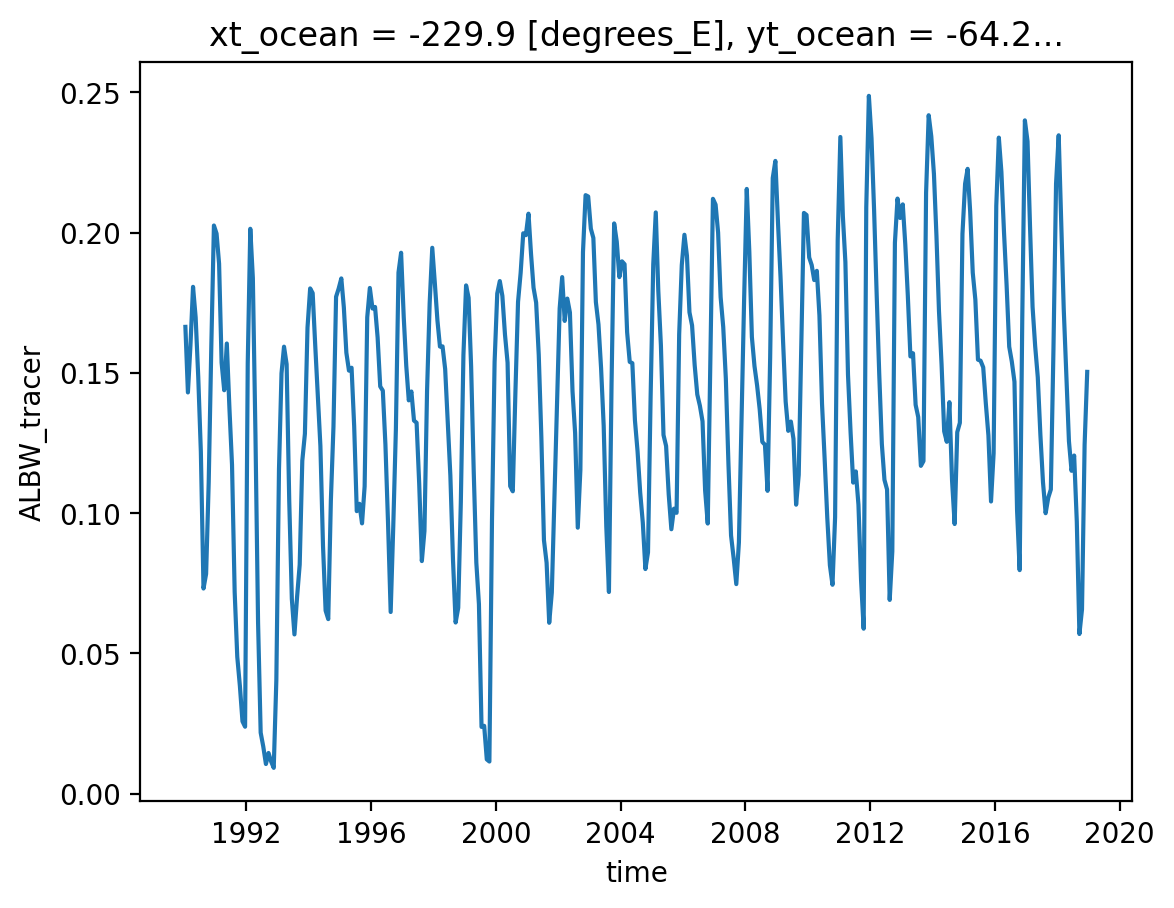

In [22]:
albw.isel(xt_ocean=500, yt_ocean=400).plot()
(albw.isel(xt_ocean=500, yt_ocean=400).groupby('time.month') - albw_clim.isel(xt_ocean=500, yt_ocean=400)).plot()

In [26]:
-230+360

130

In [16]:
albw_clim = albw.groupby('time.month').mean('time')
rsbw_clim = rsbw.groupby('time.month').mean('time')

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


In [17]:
where_nan = np.isnan(albw_clim.sel(month=1))
albw_clim = albw_clim.where(~where_nan,0)
where_nan = np.isnan(rsbw_clim.sel(month=1))
rsbw_clim = rsbw_clim.where(~where_nan,0)

In [18]:
albw_peak_month = albw_clim.argmax('month')+1
rsbw_peak_month = rsbw_clim.argmax('month')+1

In [19]:
albw_range = albw_clim.max('month') - albw_clim.min('month')
rsbw_range = rsbw_clim.max('month') - rsbw_clim.min('month')

In [20]:
save_dir = '/g/data/x77/ps7863/data/AABW_variability/'
albw_range.to_dataset().to_netcdf(f'{save_dir}ALBW_seasonal_range_{first_year}-{last_year}.nc')
rsbw_range.to_dataset().to_netcdf(f'{save_dir}RSBW_seasonal_range_{first_year}-{last_year}.nc')

In [20]:
albw_mean = helper.annual_mean_from_monthly(albw)
rsbw_mean = helper.annual_mean_from_monthly(rsbw) 

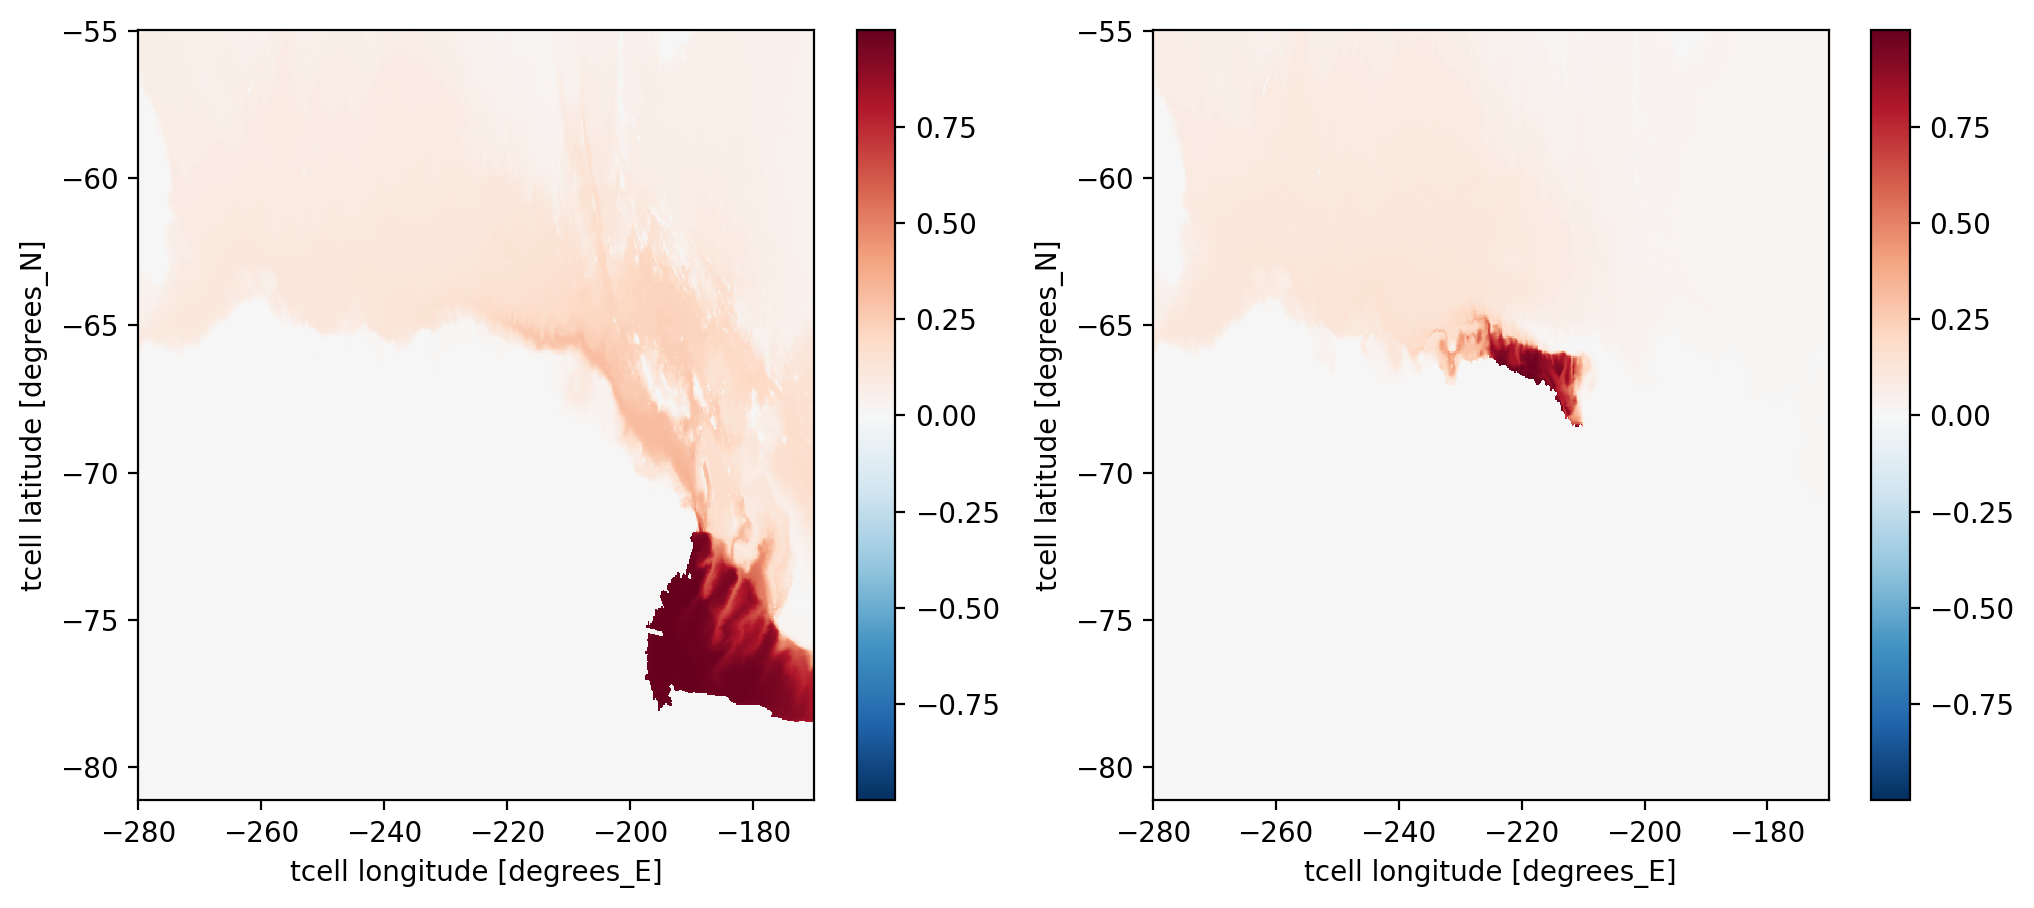

In [27]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,5))
rsbw_mean.plot(ax=axes[0])
albw_mean.plot(ax=axes[1])

In [25]:
albw_mask = albw_mean <= 0.05
albw_mask = albw_mask.astype(bool)
# albw_mask = albw_mask.where(albw_mask==0, np.nan)
albw_mask = albw_mask.where(albw_mask==1, np.nan)


rsbw_mask = rsbw_mean <= 0.05
rsbw_mask = rsbw_mask.astype(bool)
rsbw_mask = rsbw_mask.where(rsbw_mask==1, np.nan)

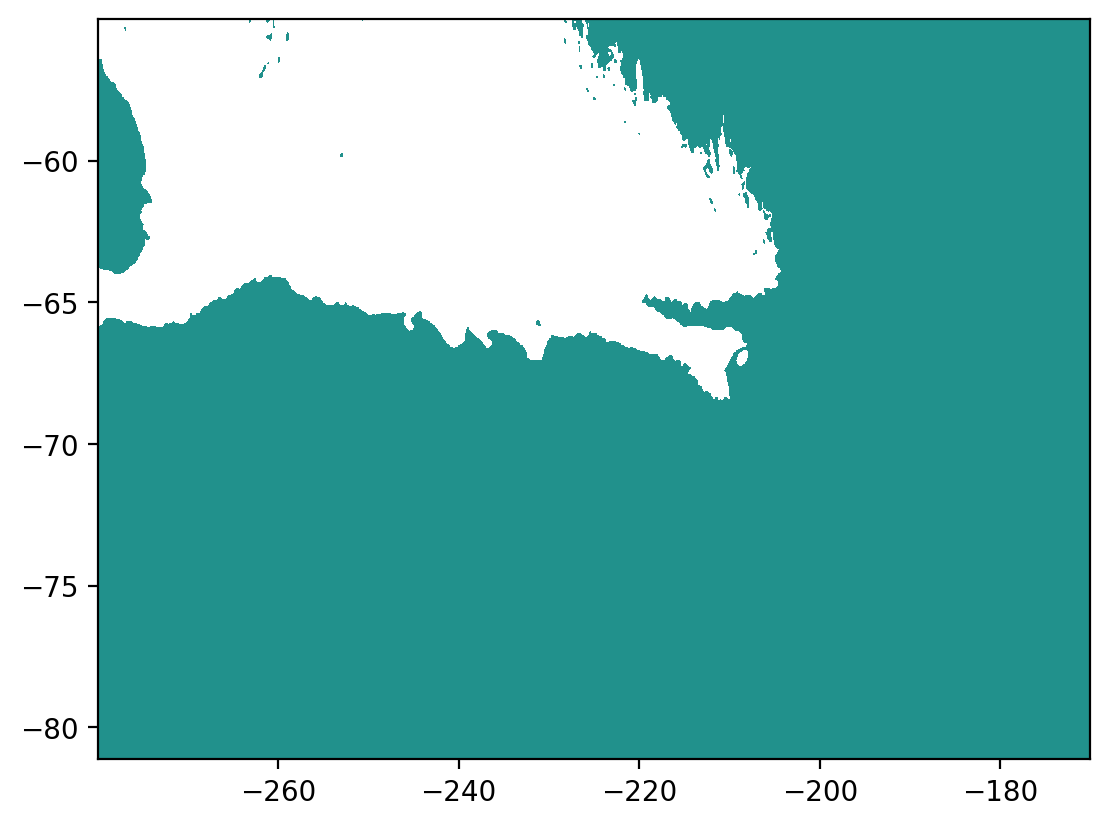

In [53]:
plt.contourf(albw_mask.xt_ocean, albw_mask.yt_ocean, albw_mask, [0, 1])

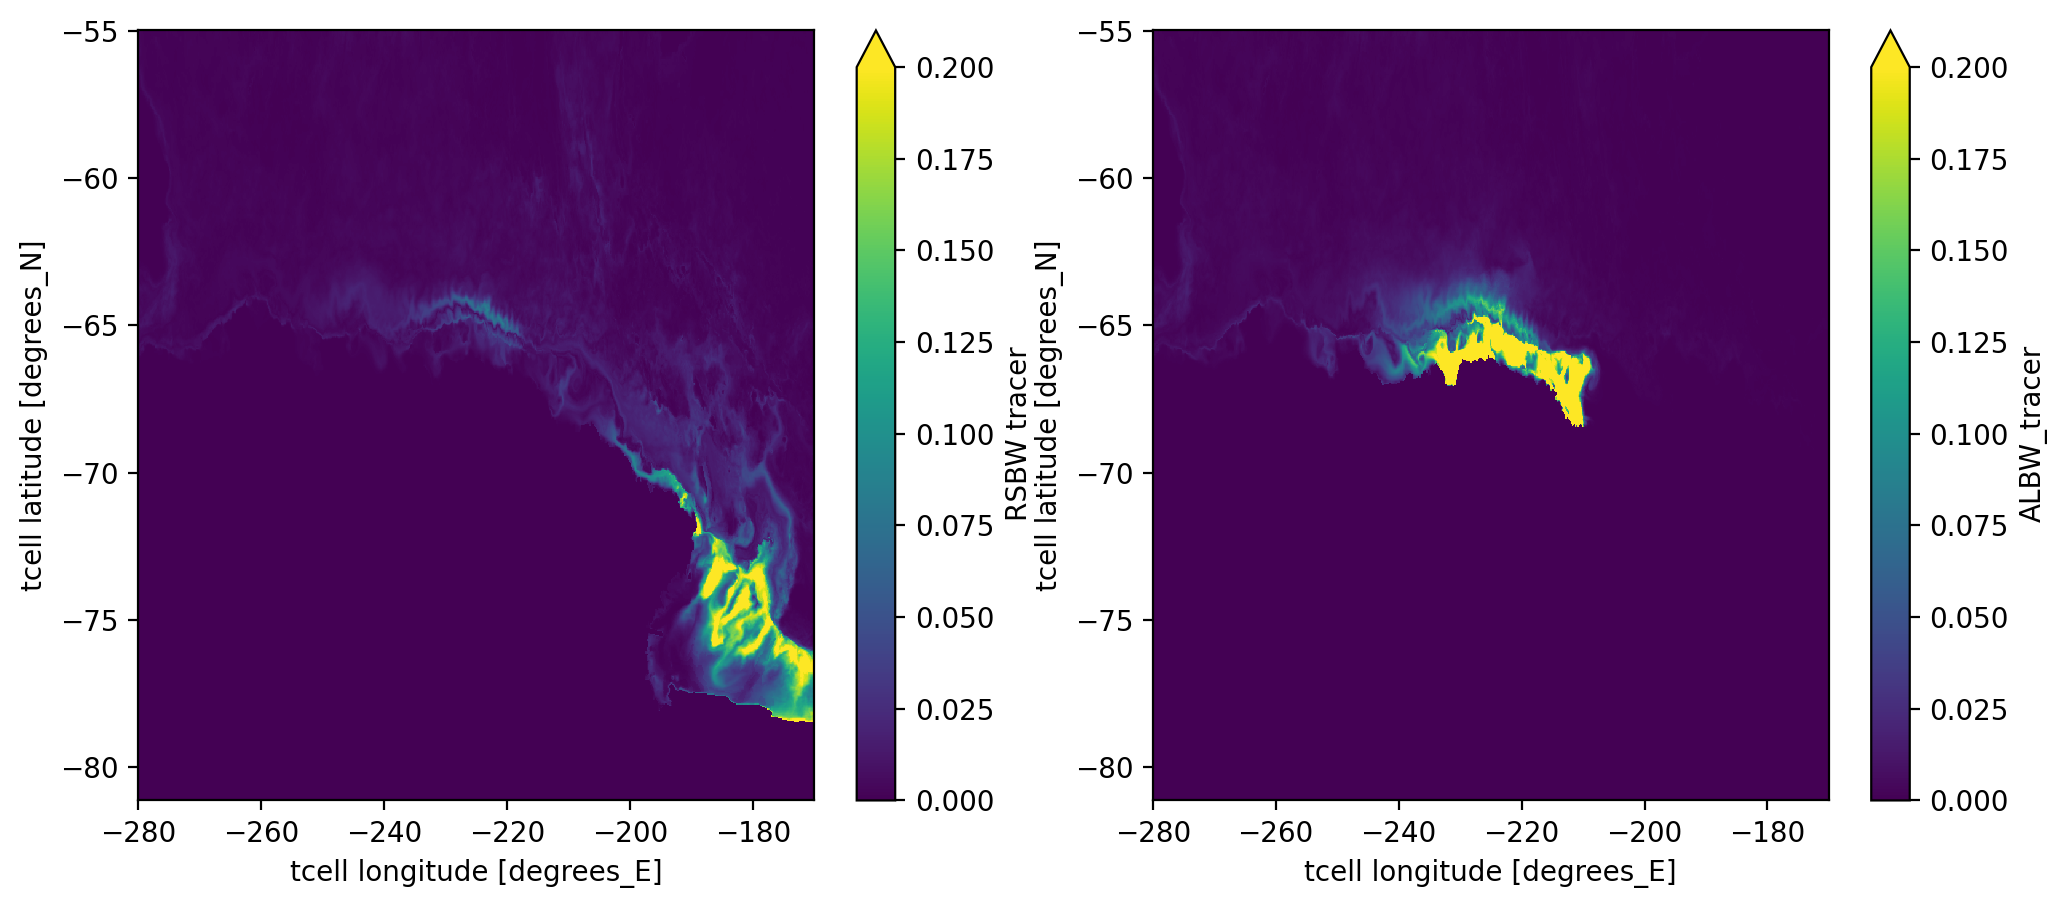

In [29]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,5))
rsbw_range.plot(ax=axes[0], vmin=0, vmax=0.2)
albw_range.plot(ax=axes[1], vmin=0, vmax=0.2)

In [26]:
albw_range_relative = albw_range / albw_mean * 100
rsbw_range_relative = rsbw_range / rsbw_mean * 100

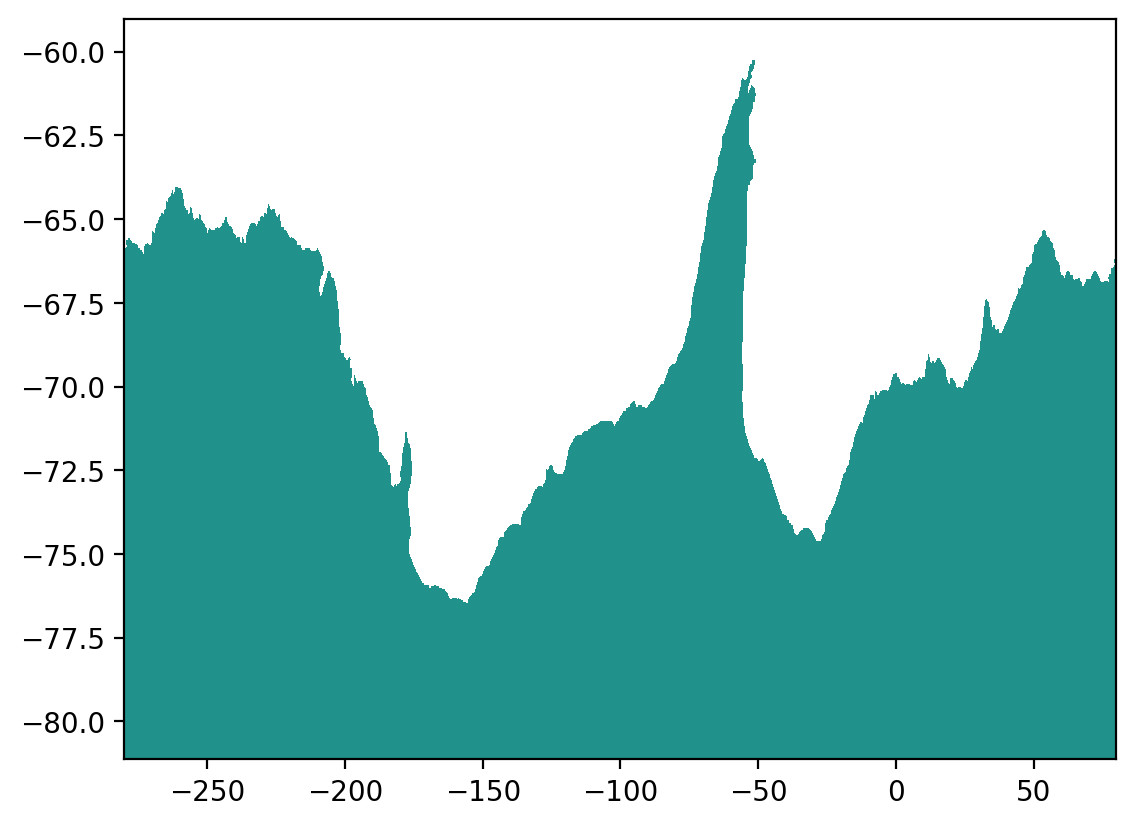

In [66]:
plt.contourf(shelf.xt_ocean, shelf.yt_ocean, shelf, [0.5, 1])


NameError: name 'albw_mask' is not defined

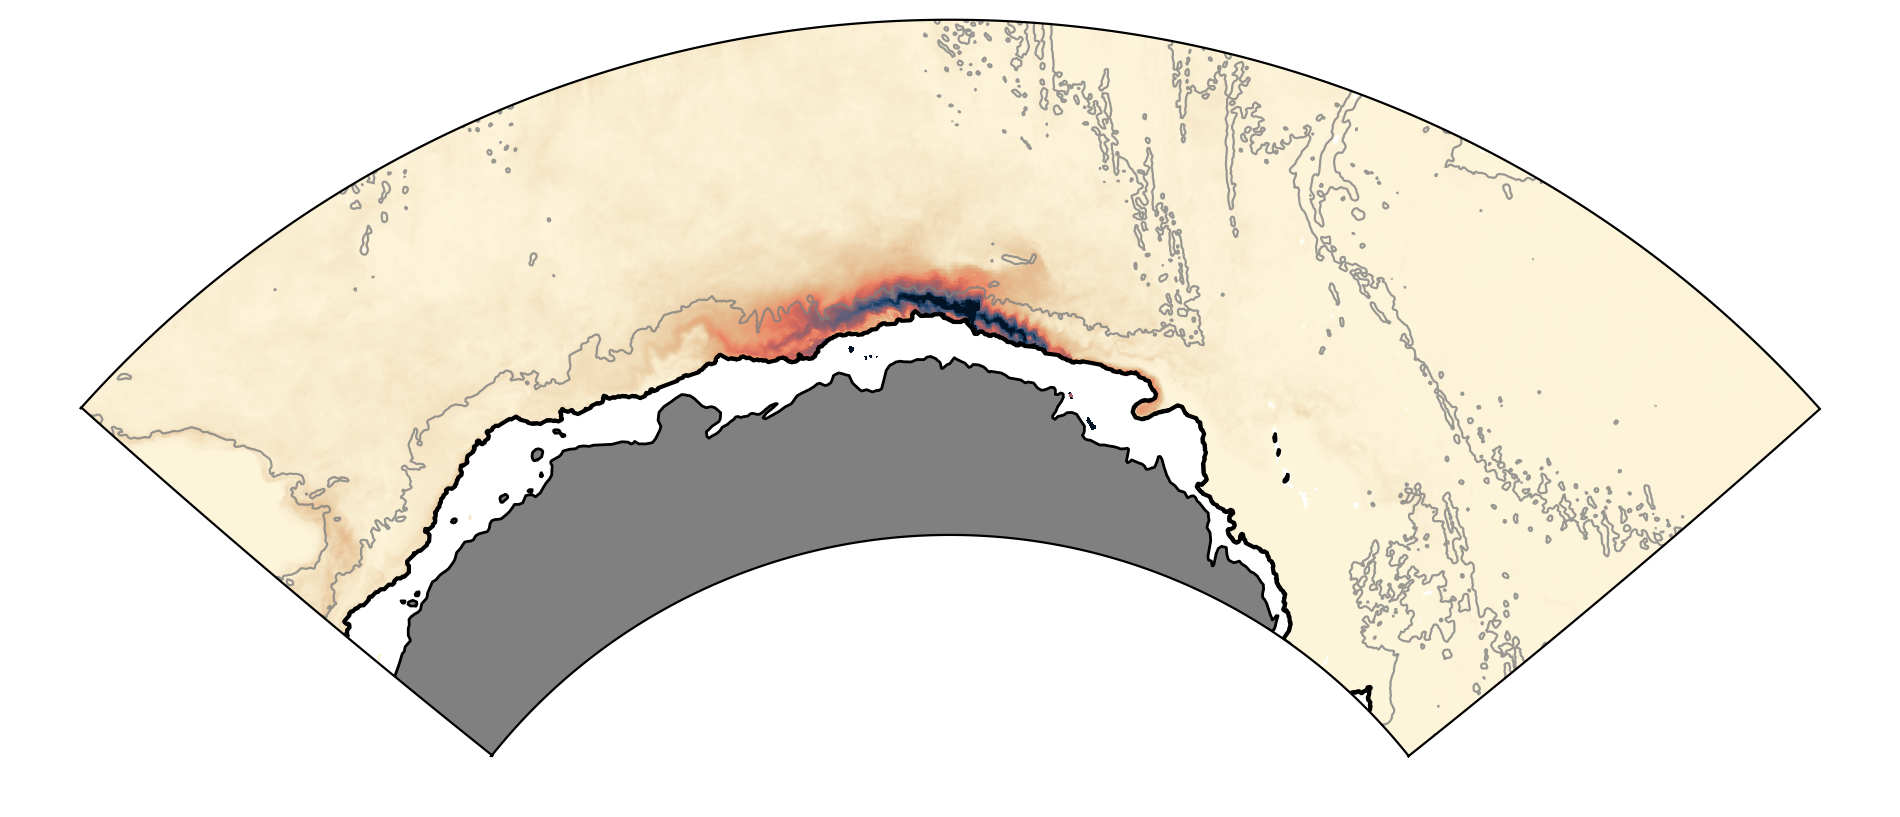

In [23]:
midlon = -225
maxlon = midlon + 60
minlon = midlon - 60
minlat = -72
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())


ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())


norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.06, vmax=0.12)
cmap = cmcrameri.cm.lipari_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, albw_range*shelf_mask, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

ax.contourf(albw_mask.xt_ocean, albw_mask.yt_ocean, albw_mask, [0, 1],  transform=ccrs.PlateCarree(), colors='lightgrey')
ax.contourf(shelf.xt_ocean, shelf.yt_ocean, shelf, [0.5, 1], transform=ccrs.PlateCarree(), colors='white')


cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label(f'Tracer concentration')
plt.suptitle(f'Seasonal range of ALBW, {first_year}-{last_year}')




plt.savefig(f'{figdir}/albw_range_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


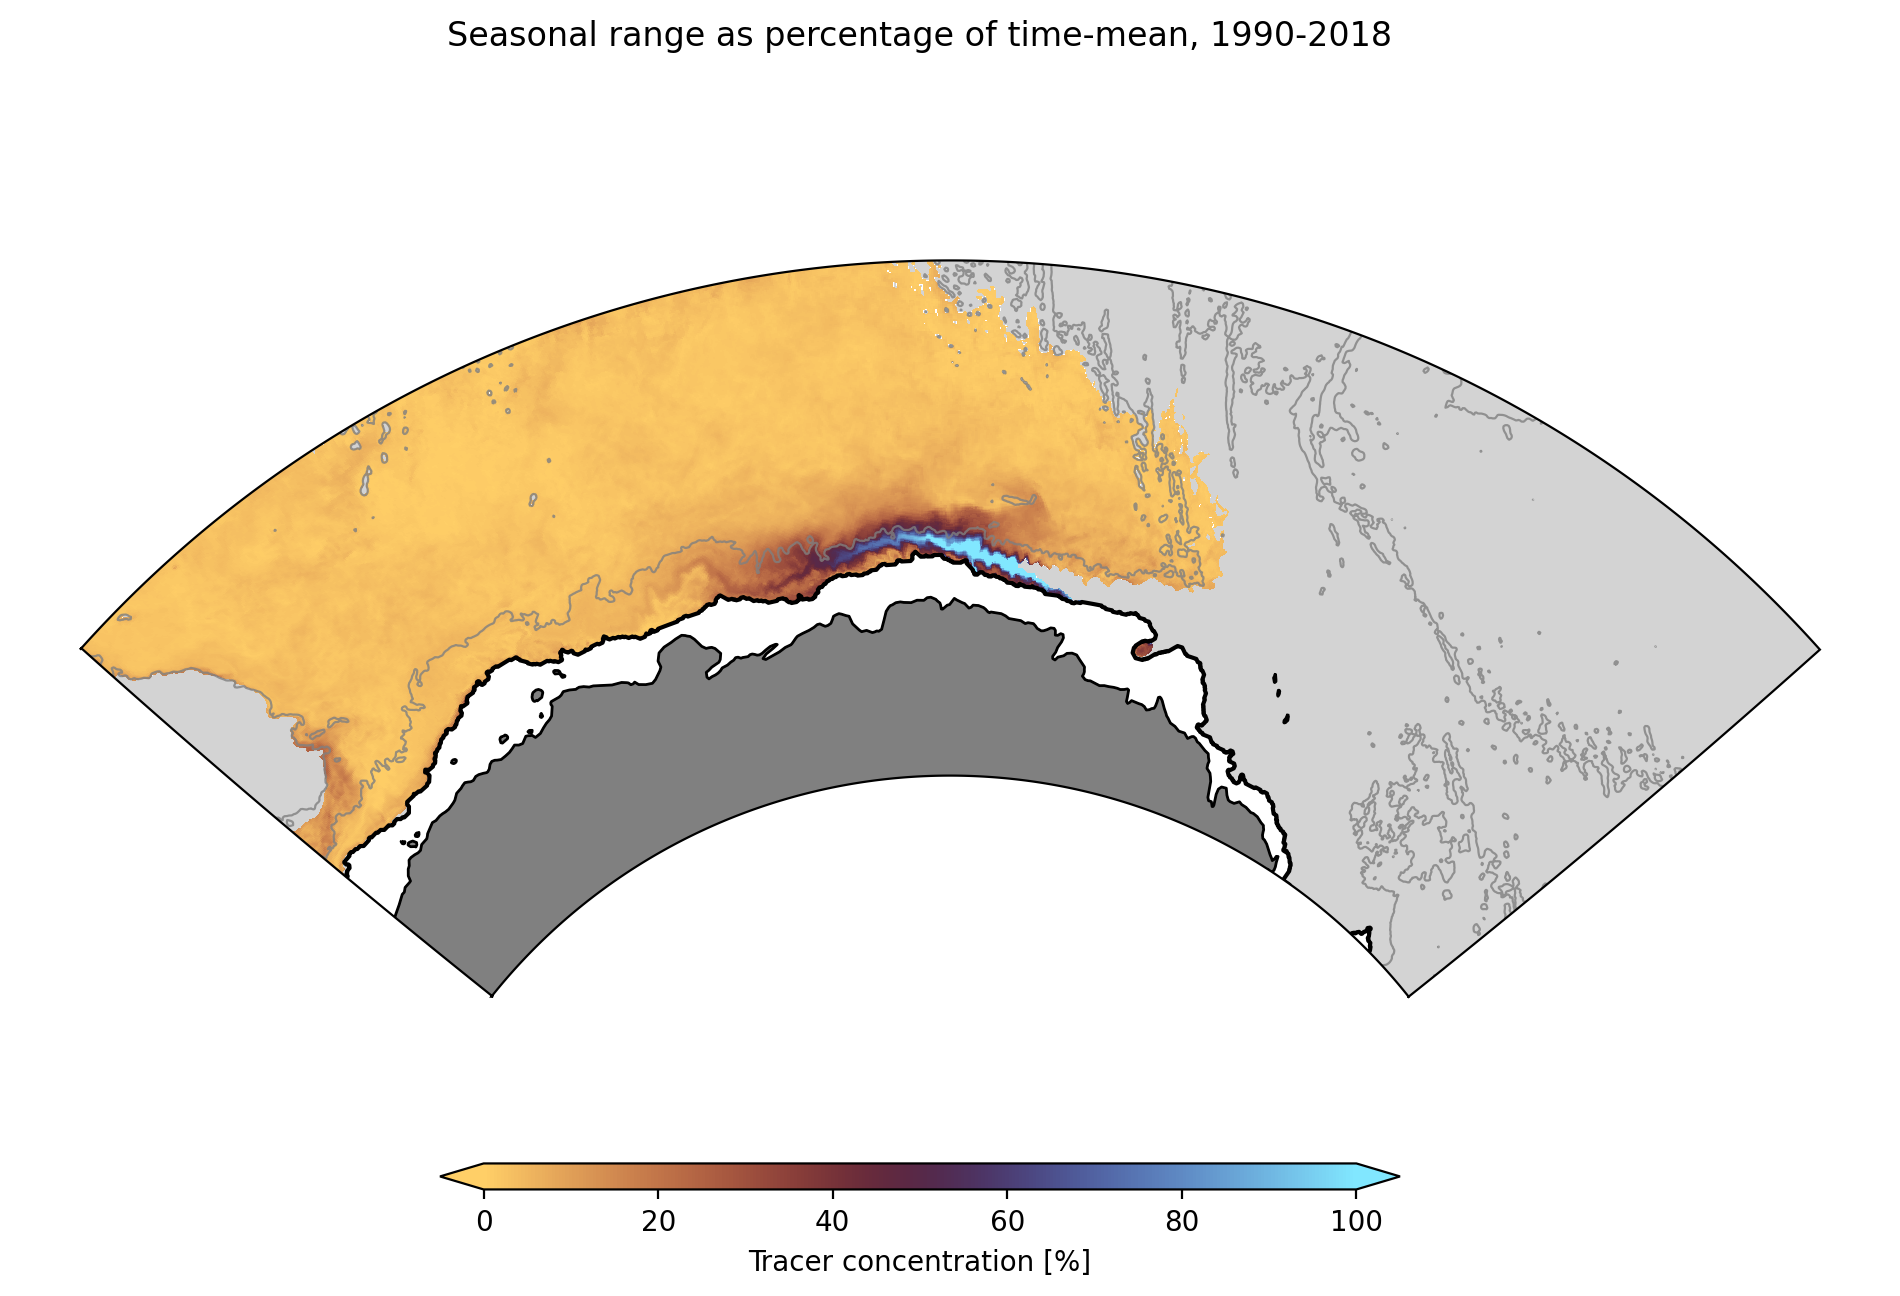

In [83]:
midlon = -225
maxlon = midlon + 60
minlon = midlon - 60
minlat = -72
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())


ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

ax.contourf(shelf.xt_ocean, shelf.yt_ocean, shelf, [0,0.5])

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=50, vmax=100)
cmap = cmcrameri.cm.managua
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, (albw_range_relative*shelf_mask).where(albw_mean>=0.05), norm=norm, cmap=cmap, transform=ccrs.PlateCarree())

ax.contourf(albw_mask.xt_ocean, albw_mask.yt_ocean, albw_mask, [0, 1],  transform=ccrs.PlateCarree(), colors='lightgrey')
ax.contourf(shelf.xt_ocean, shelf.yt_ocean, shelf, [0.5, 1], transform=ccrs.PlateCarree(), colors='white')

cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label(f'Tracer concentration [%]')
# plt.suptitle(f'Seasonal range as percentage of time-mean, {first_year}-{last_year}')


plt.savefig(f'{figdir}/albw_range_relative_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


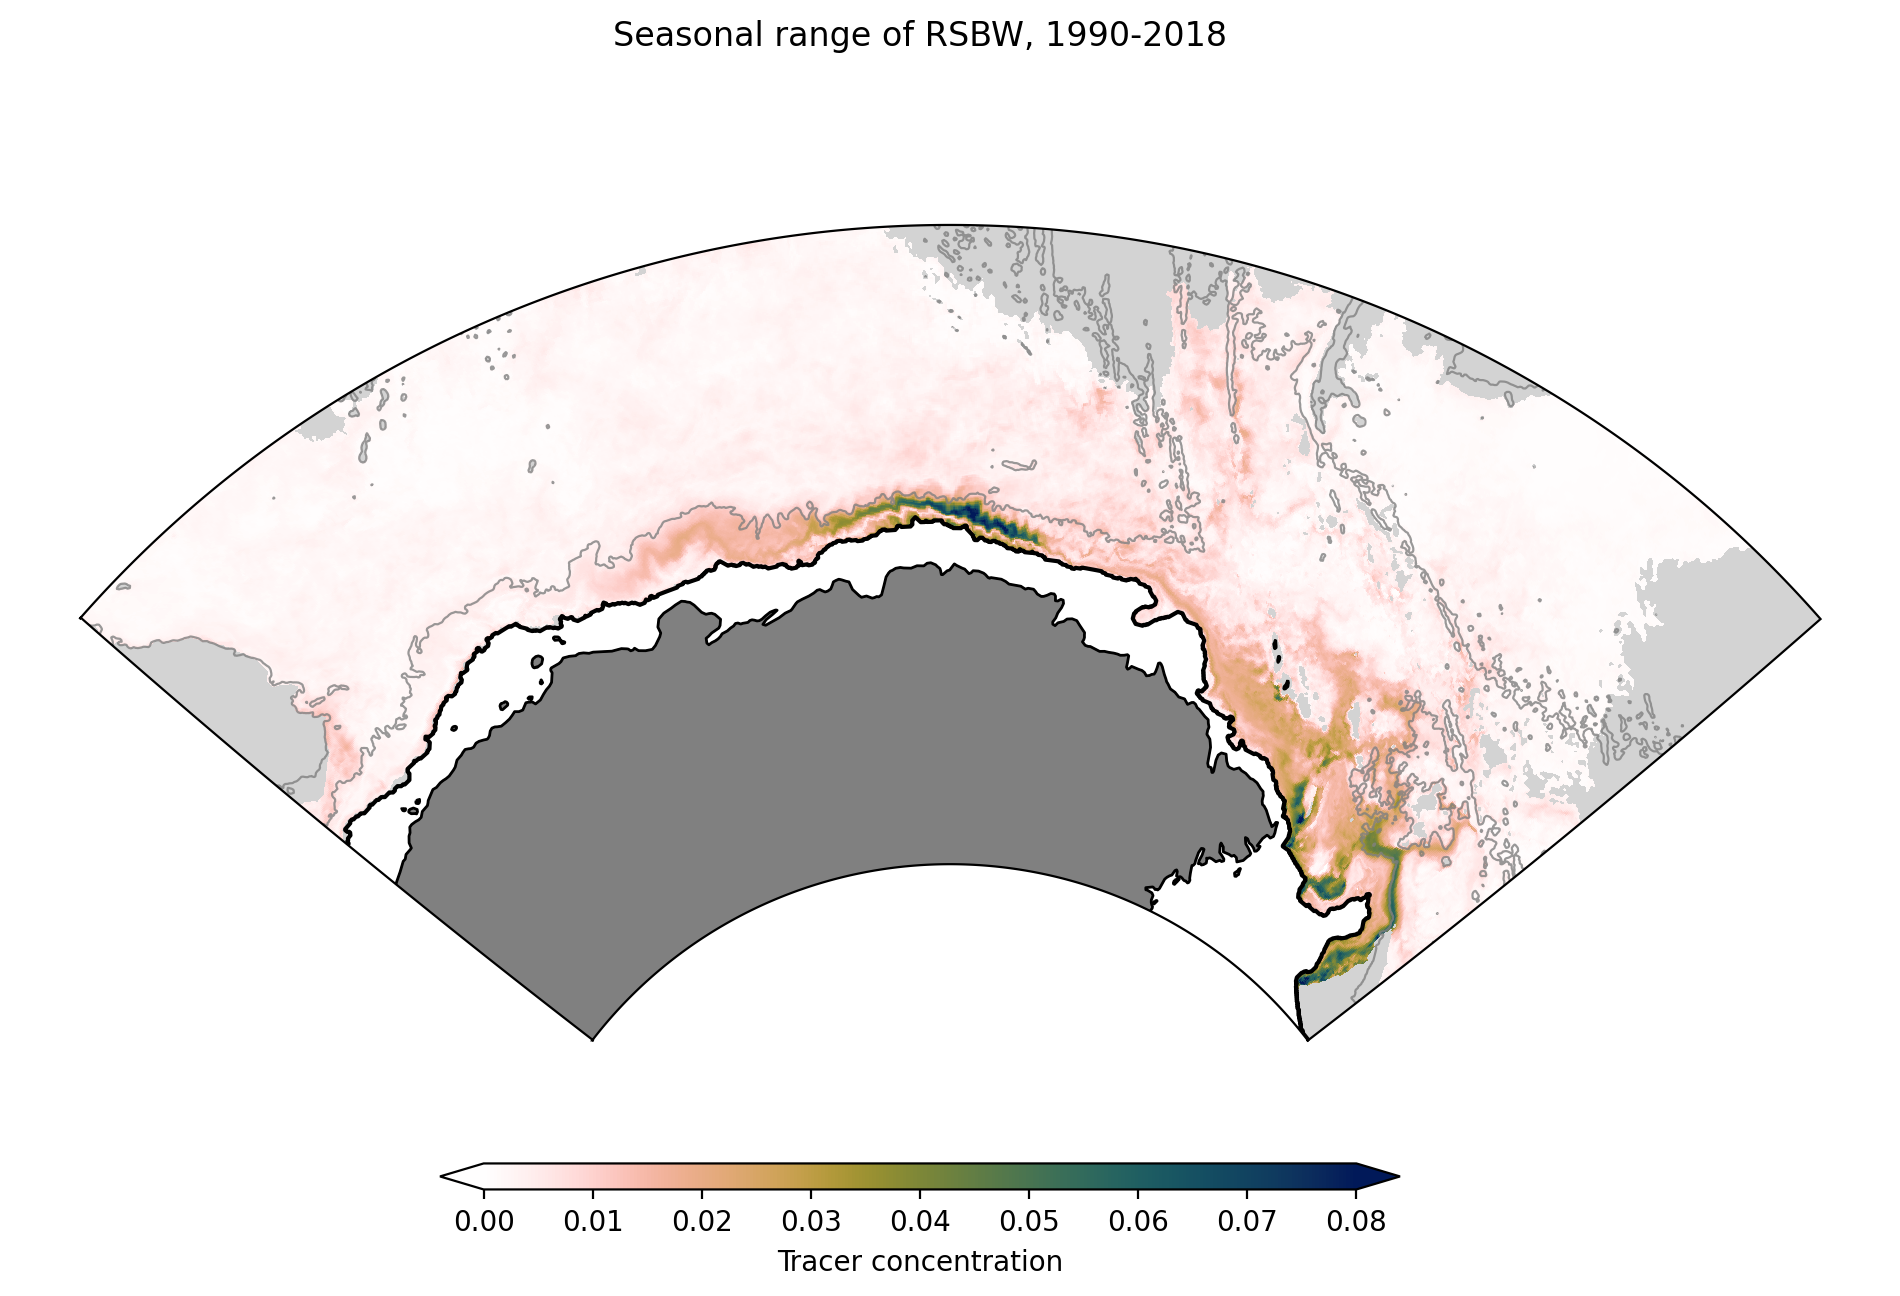

In [76]:
midlon = -225
maxlon = midlon + 60
minlon = midlon - 60
minlat = -76
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())


ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.04, vmax=0.08)
cmap = cmcrameri.cm.batlowW_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, rsbw_range*shelf_mask, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

ax.contourf(rsbw_mask.xt_ocean, rsbw_mask.yt_ocean, rsbw_mask, [0, 1],  transform=ccrs.PlateCarree(), colors='lightgrey')
ax.contourf(shelf.xt_ocean, shelf.yt_ocean, shelf, [0.5, 1], transform=ccrs.PlateCarree(), colors='white')

cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label(f'Tracer concentration')
plt.suptitle(f'Seasonal range of RSBW, {first_year}-{last_year}')


plt.savefig(f'{figdir}/rsbw_range_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


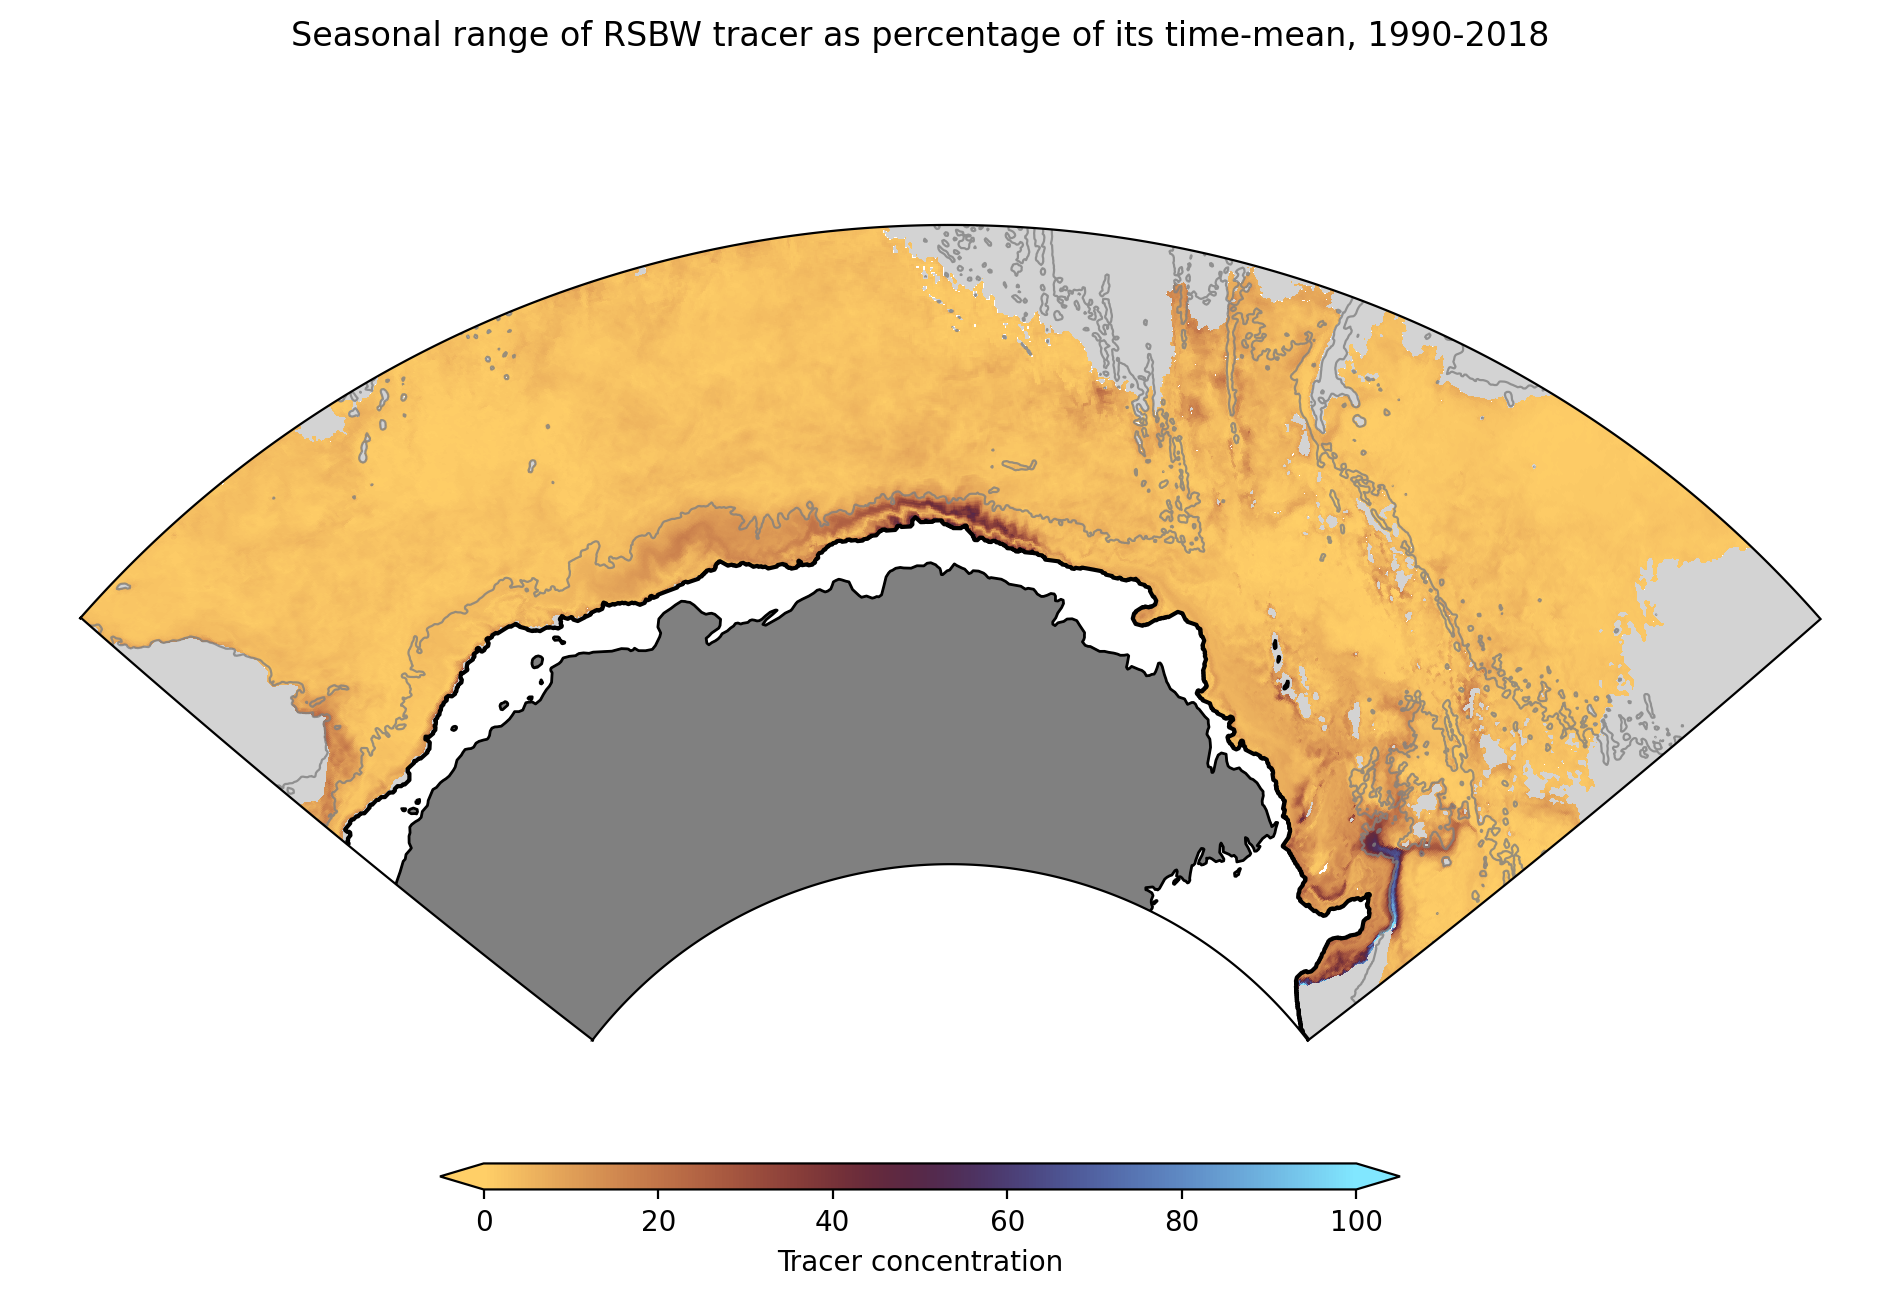

In [28]:
midlon = -225
maxlon = midlon + 60
minlon = midlon - 60
minlat = -76
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())


ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=50, vmax=100)
cmap = cmcrameri.cm.managua
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, (rsbw_range_relative*shelf_mask).where(rsbw_mean>=0.05), cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

ax.contourf(rsbw_mask.xt_ocean, rsbw_mask.yt_ocean, rsbw_mask, [0, 1],  transform=ccrs.PlateCarree(), colors='lightgrey')
ax.contourf(shelf.xt_ocean, shelf.yt_ocean, shelf, [0.5, 1], transform=ccrs.PlateCarree(), colors='white')

cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label(f'Tracer concentration')
plt.suptitle(f'Seasonal range of RSBW tracer as percentage of its time-mean, {first_year}-{last_year}')


plt.savefig(f'{figdir}/rsbw_range_relative_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


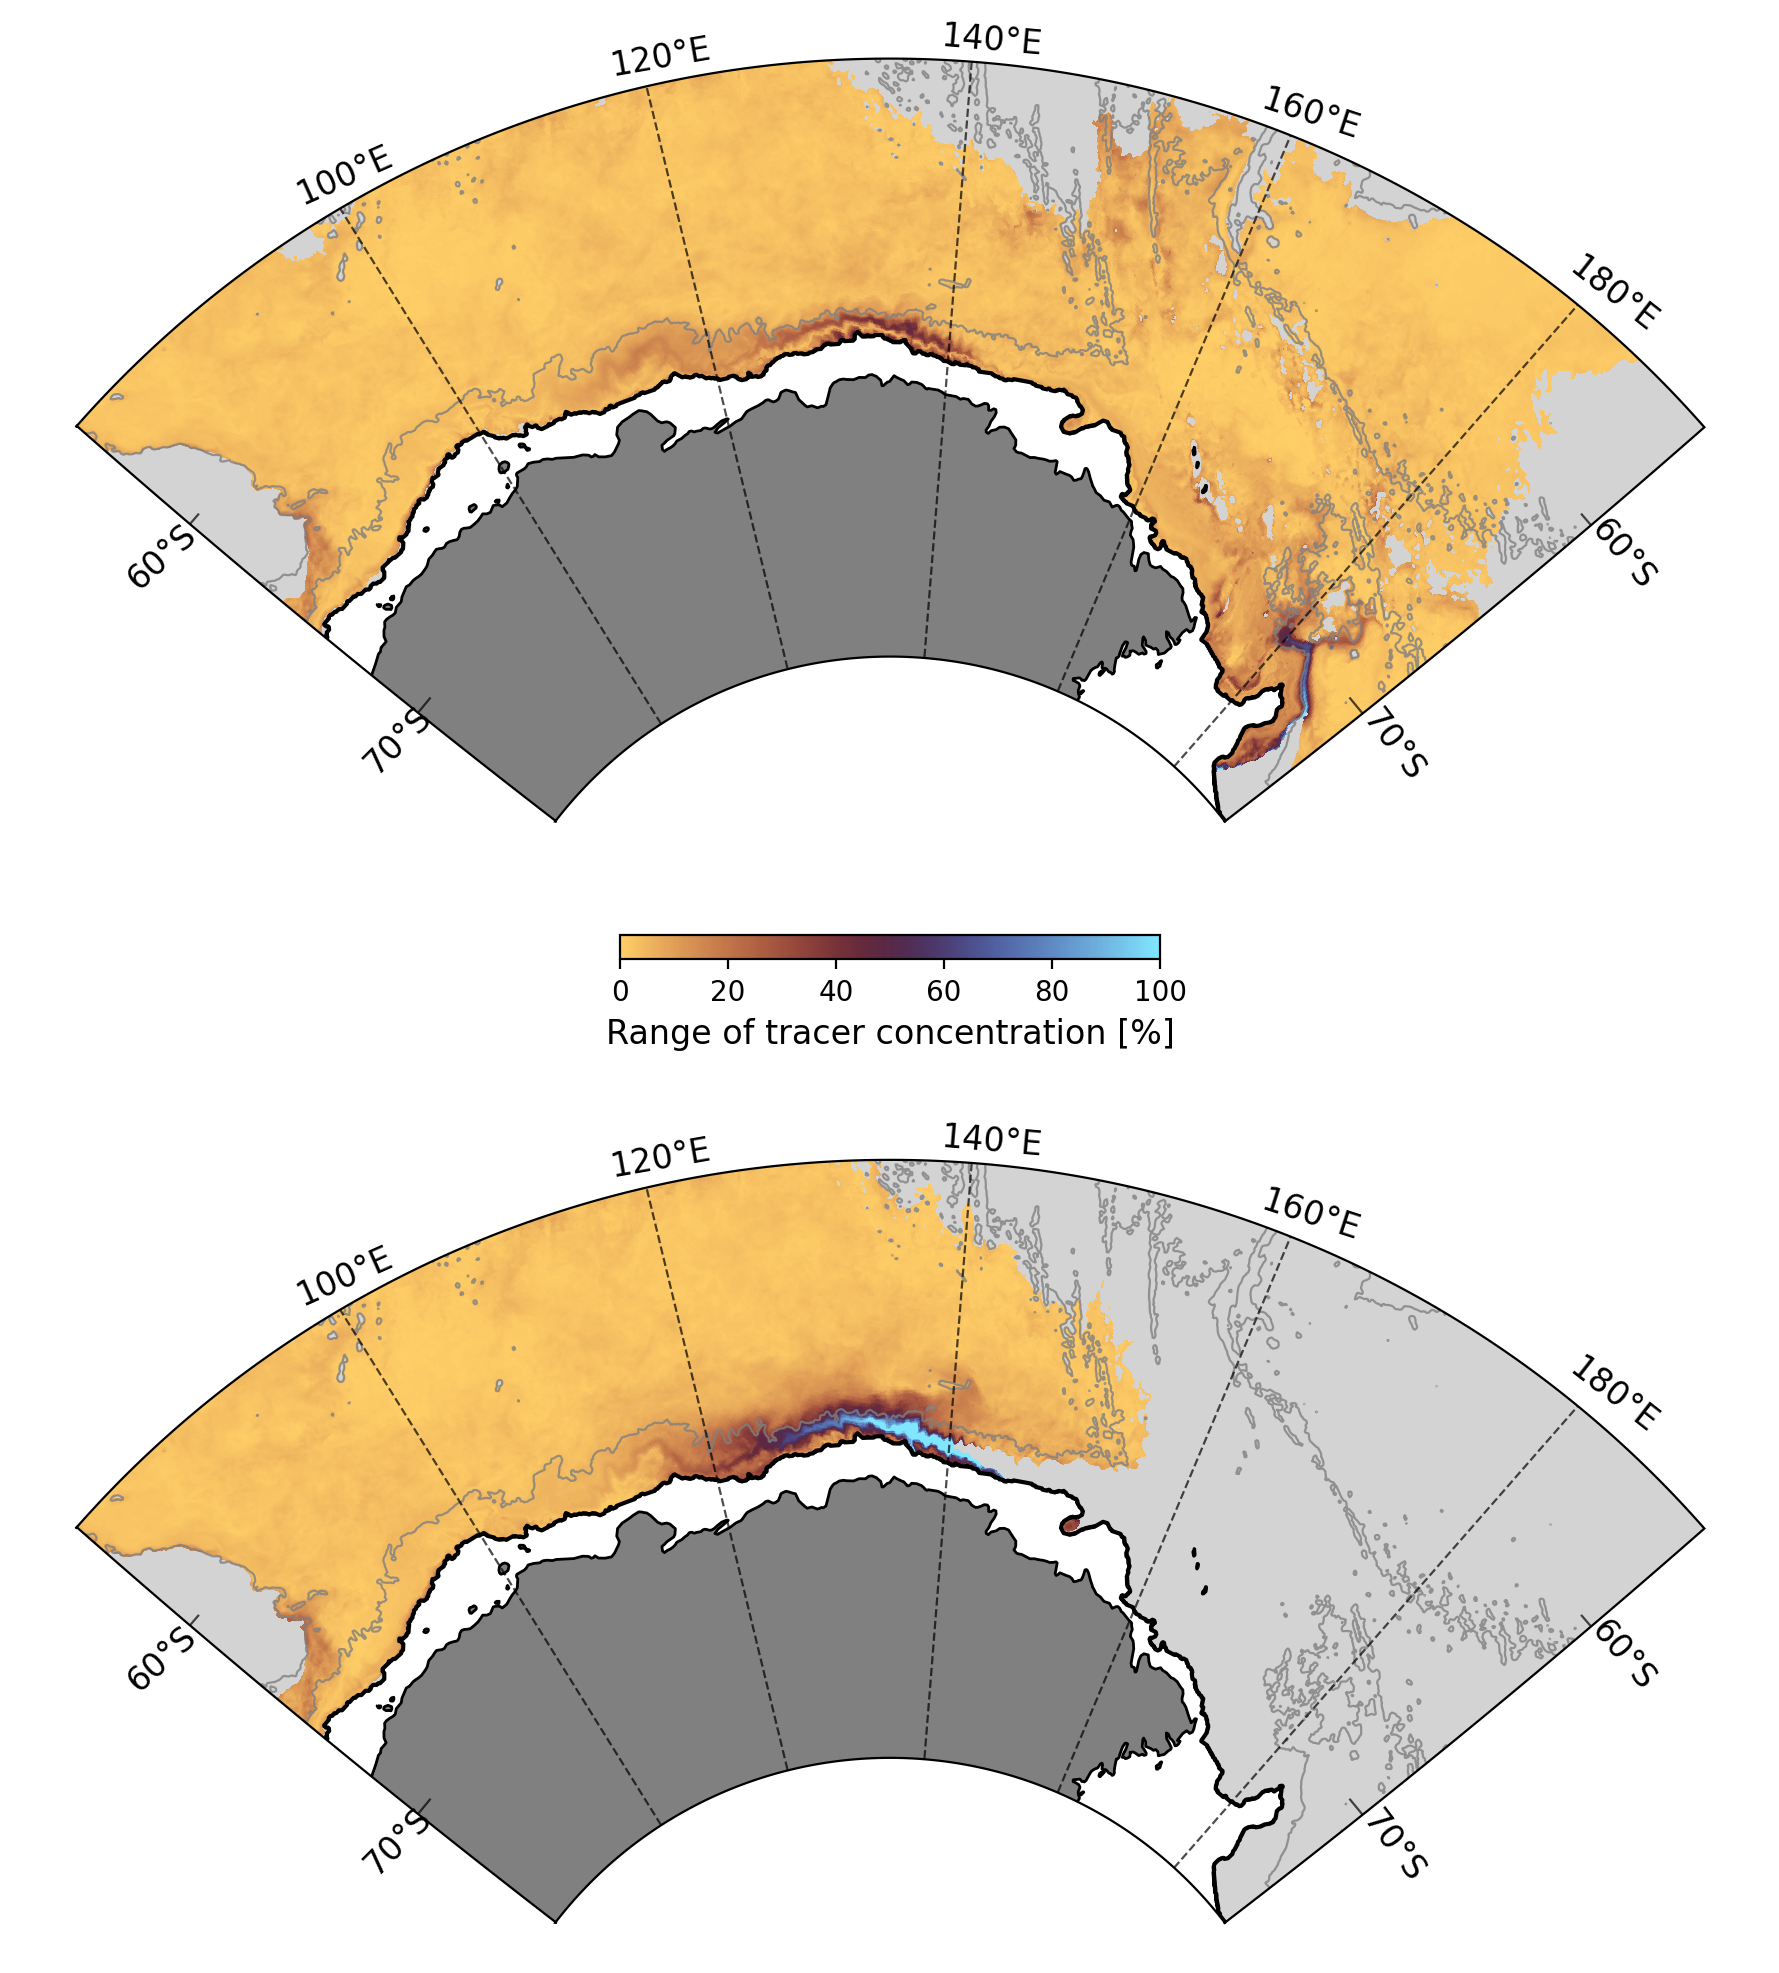

In [35]:
projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=50, vmax=100)
cmap = cmcrameri.cm.managua
cm = 1/2.54
fig, axes = plt.subplots(
    nrows=2, 
    ncols=1, 
    subplot_kw={'projection': projection}, 
    figsize=(9, 12)
)

for i, ax in enumerate(axes):
    ax.add_feature(land_50m)  # Assuming 'land_50m' is predefined
    ax.coastlines(resolution="50m")
    ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

    # Create lons and lats slices (assuming X and Y are xarray objects)
    lons = X.sel({"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)})
    lats = Y.sel({"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)})

    # Set boundary path (assuming make_boundary_path is a function that takes lons, lats)
    boundary_path = make_boundary_path(lons, lats)
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

    ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

    ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                    levels=[3500],
                    colors='grey',
                    linewidths=.8,
                    alpha=.8,
                    transform=ccrs.PlateCarree())
    ax.plot([100,100], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([120,120], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([140,140], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([160,160], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([180,180], [-80, -50], linestyle='--', c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([80,81], [-60, -60], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([80,82], [-70, -70], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([189,190], [-60, -60], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    ax.plot([188,190], [-70, -70], c='k', alpha=0.7, linewidth=0.8, transform=ccrs.PlateCarree())
    
    text_size = 12
    ax.text(98,-54, s=f'100{degree}E', transform=ccrs.PlateCarree(), rotation=24, fontsize=text_size)
    ax.text(118,-54.3, s=f'120{degree}E', transform=ccrs.PlateCarree(), rotation=10, fontsize=text_size)
    ax.text(138,-54.8, s=f'140{degree}E', transform=ccrs.PlateCarree(), rotation=-5, fontsize=text_size)
    ax.text(158,-55.5, s=f'160{degree}E', transform=ccrs.PlateCarree(), rotation=-18, fontsize=text_size)
    ax.text(180,-56, s=f'180{degree}E', transform=ccrs.PlateCarree(), rotation=-38, fontsize=text_size)
    
    ax.text(74,-59.5, s=f'60{degree}S', transform=ccrs.PlateCarree(), rotation=42, fontsize=text_size)
    ax.text(72,-69.5, s=f'70{degree}S', transform=ccrs.PlateCarree(), rotation=45, fontsize=text_size)
    ax.text(193,-61.5, s=f'60{degree}S', transform=ccrs.PlateCarree(), rotation=-50, fontsize=text_size)
    ax.text(195,-71.5, s=f'70{degree}S', transform=ccrs.PlateCarree(), rotation=-53, fontsize=text_size)


pc = axes[0].pcolormesh(ht.xt_ocean+360, ht.yt_ocean, rsbw_range_relative, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
axes[0].contourf(rsbw_mask.xt_ocean, rsbw_mask.yt_ocean, rsbw_mask, [0, 1],  transform=ccrs.PlateCarree(), colors='lightgrey')
axes[0].contourf(shelf.xt_ocean, shelf.yt_ocean, shelf, [0.5, 1], transform=ccrs.PlateCarree(), colors='white')


pc2 = axes[1].pcolormesh(ht.xt_ocean+360, ht.yt_ocean, albw_range_relative, norm=norm, cmap=cmap, transform=ccrs.PlateCarree())
axes[1].contourf(albw_mask.xt_ocean, albw_mask.yt_ocean, albw_mask, [0, 1],  transform=ccrs.PlateCarree(), colors='lightgrey')
axes[1].contourf(shelf.xt_ocean, shelf.yt_ocean, shelf, [0.5, 1], transform=ccrs.PlateCarree(), colors='white')

cbar_ax = fig.add_axes([0.35, 0.52, 0.3, 0.01])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', spacing='proportional')
cbar.set_label('Range of tracer concentration [%]', fontsize=12)

plt.tight_layout()
figtit = 'seasonal_range_RSBW+ALBW'

plt.savefig(f'{figdir}/{figtit}.png', dpi=300, bbox_inches='tight')

In [14]:
temp = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/temperature_in_the_bottom_500m_1958-2018.nc')
salt = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/salinity_in_the_bottom_500m_1958-2018.nc')
age = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/age_in_the_bottom_500m_1958-2018.nc')
sigma2 = xr.open_dataset('/g/data/x77/ps7863/data/AABW_variability/sigma2_in_the_bottom_500m_1958-2018.nc')

In [15]:
temp = temp['__xarray_dataarray_variable__']
salt = salt['__xarray_dataarray_variable__']
age = age['__xarray_dataarray_variable__']
sigma = sigma2['__xarray_dataarray_variable__']

In [16]:
temp = temp.sel(xt_ocean=lon_slice, yt_ocean=lat_slice)
salt = salt.sel(xt_ocean=lon_slice, yt_ocean=lat_slice)
age = age.sel(xt_ocean=lon_slice, yt_ocean=lat_slice)
sigma = sigma.sel(xt_ocean=lon_slice, yt_ocean=lat_slice)

In [17]:
age_clim = age.groupby('time.month').mean('time')
salt_clim = salt.groupby('time.month').mean('time')
temp_clim = temp.groupby('time.month').mean('time')
sigma_clim = sigma.groupby('time.month').mean('time') 

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


In [18]:
age_range = (age_clim.max(dim='month') - age_clim.min(dim='month')).load()
salt_range = (salt_clim.max(dim='month') - salt_clim.min(dim='month')).load()
temp_range = (temp_clim.max(dim='month') - temp_clim.min(dim='month')).load()
sigma2_range = (sigma_clim.max(dim='month') - sigma_clim.min(dim='month')).load()

In [35]:
temp_range.shape, rsbw_range.shape

((510, 1100), (584, 1100))

In [19]:
def add_colorbar(ax, data, ticks=None, extend=None):
    fontsize = 12
    axins = inset_axes(ax, width = "3%", height = "100%", loc = 'lower left',
                   bbox_to_anchor = (1.02, 0., 1, 1), bbox_transform = ax.transAxes,
                   borderpad = 0)
    cbar = fig.colorbar(data, cax = axins, ticks=ticks, extend=extend)
    return cbar

NameError: name 'ax1' is not defined

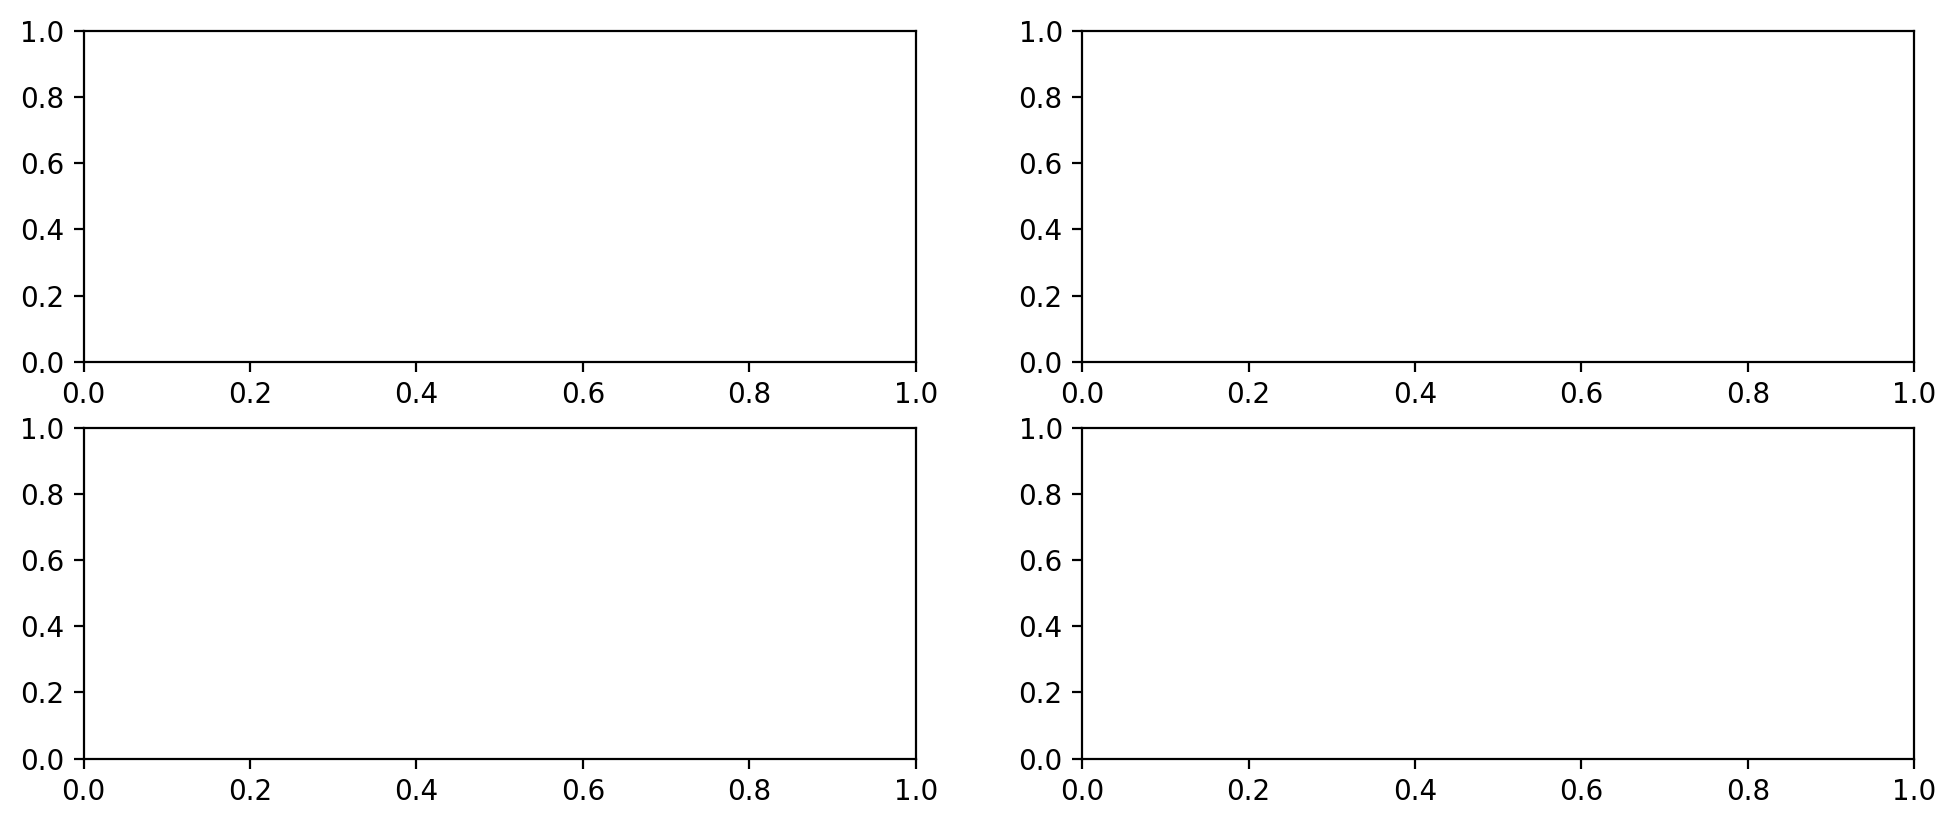

In [20]:
cm = 1/2.54
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30*cm, 12*cm))


# Temperature subplot
# ax1 = plt.subplot(221)
# norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.2, vmax=0.4)
# cmap = cmcrameri.cm.lipari_r
# pc1 = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, temp_range, cmap=cmap, norm=norm)
helper.fix_plot(ax=ax1, ht=ht, land_mask=land_mask_masked, axes_labels=True)
# cbar1 = add_colorbar(ax1, data=pc1, extend='max')
# cbar1.set_label(f'Bottom temperature [{degree}C]')

# Salinity subplot
ax2 = plt.subplot(222)
cmap = cmcrameri.cm.glasgow_r
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.01, vmax=0.02)
pc2 = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, salt_range, cmap=cmap, norm=norm)
helper.fix_plot(ax=ax2, ht=ht, land_mask=land_mask_masked, axes_labels=True)
cbar2 = add_colorbar(ax2, data=pc2, extend='max')
cbar2.set_label('Bottom salinity [psu]')


# Density subplot
ax3 = plt.subplot(223)
cmap = cmcrameri.cm.batlowW_r
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.02, vmax=0.04)
pc3 = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, sigma2_range, cmap=cmap, norm=norm)
helper.fix_plot(ax=ax3, ht=ht, land_mask=land_mask_masked, axes_labels=True)
cbar3 = add_colorbar(ax3, data=pc3)
cbar3.set_label('Bottom $\sigma_2$ [kg m$^{-3}$]')

# Age subplot
ax4 = plt.subplot(224)
cmap = cmcrameri.cm.lapaz_r
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=2, vmax=4)
pc4 = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, age_range,cmap=cmap, norm=norm)
helper.fix_plot(ax=ax4, ht=ht, land_mask=land_mask_masked, axes_labels=True)
cbar4 = add_colorbar(ax4, data=pc4,extend='max')
cbar4.set_label('Bottom age')

axes = [ax1, ax2, ax3, ax4]
for ax in axes:
    ax.set_xlim(80, 190)
    ax.set_ylim(-78,-55)

figtit = 'AABW_seasonal_range'
plt.savefig(f'{figdir}/{figtit}.png', dpi=250, bbox_inches='tight')

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [22]:
land_50m = cfeature.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="black", facecolor="grey", linewidth=0.5
)

In [23]:
xt_ocean = ht.xt_ocean
yt_ocean = ht.yt_ocean

In [24]:
X, Y = np.meshgrid(xt_ocean, yt_ocean)
X = xr.DataArray(X, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])
Y = xr.DataArray(Y, coords=[yt_ocean, xt_ocean], dims=['yt_ocean', 'xt_ocean'])

In [25]:
def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """

    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(
        boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[1, ::-1], latitudes[1, ::-1]]), axis=1
    )
    boundary_path = np.append(
        boundary_path, np.array([longitudes[:, 1], latitudes[:, 1]]), axis=1
    )
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

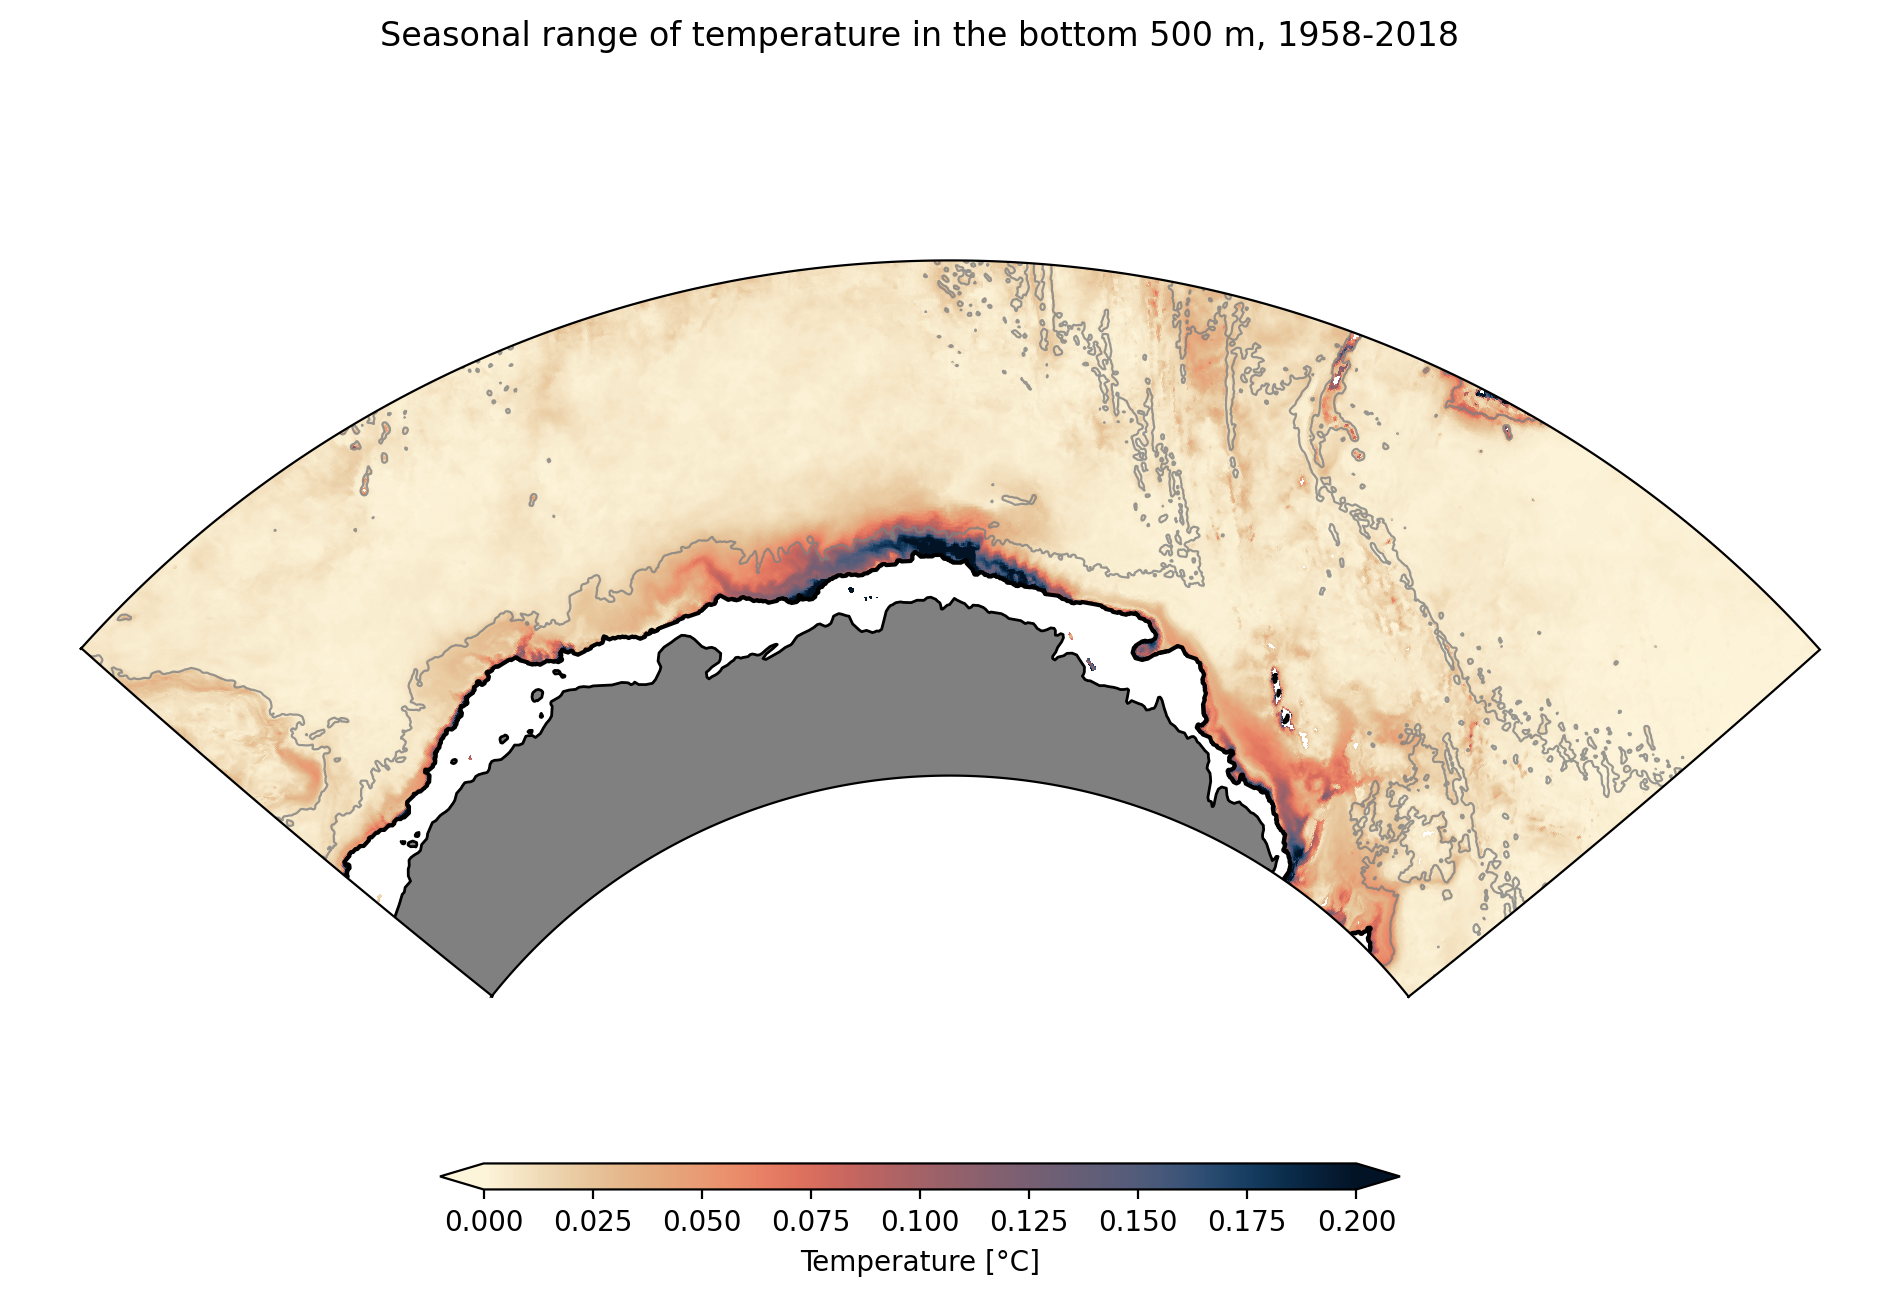

In [26]:
midlon = -225
maxlon = midlon + 60
minlon = midlon - 60
minlat = -72
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

# To plot 1000-m contour
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf[np.where(shelf!=0)] = np.nan
shelf = shelf+1
shelf = np.nan_to_num(shelf)
shelf = xr.DataArray(shelf, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])


ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.1, vmax=0.2)
cmap = cmcrameri.cm.lipari_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, temp_range, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label(f'Temperature [{degree}C]')
plt.suptitle(f'Seasonal range of temperature in the bottom 500 m, {first_year}-{last_year}')

plt.savefig(f'{figdir}/bottom_temp_range_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


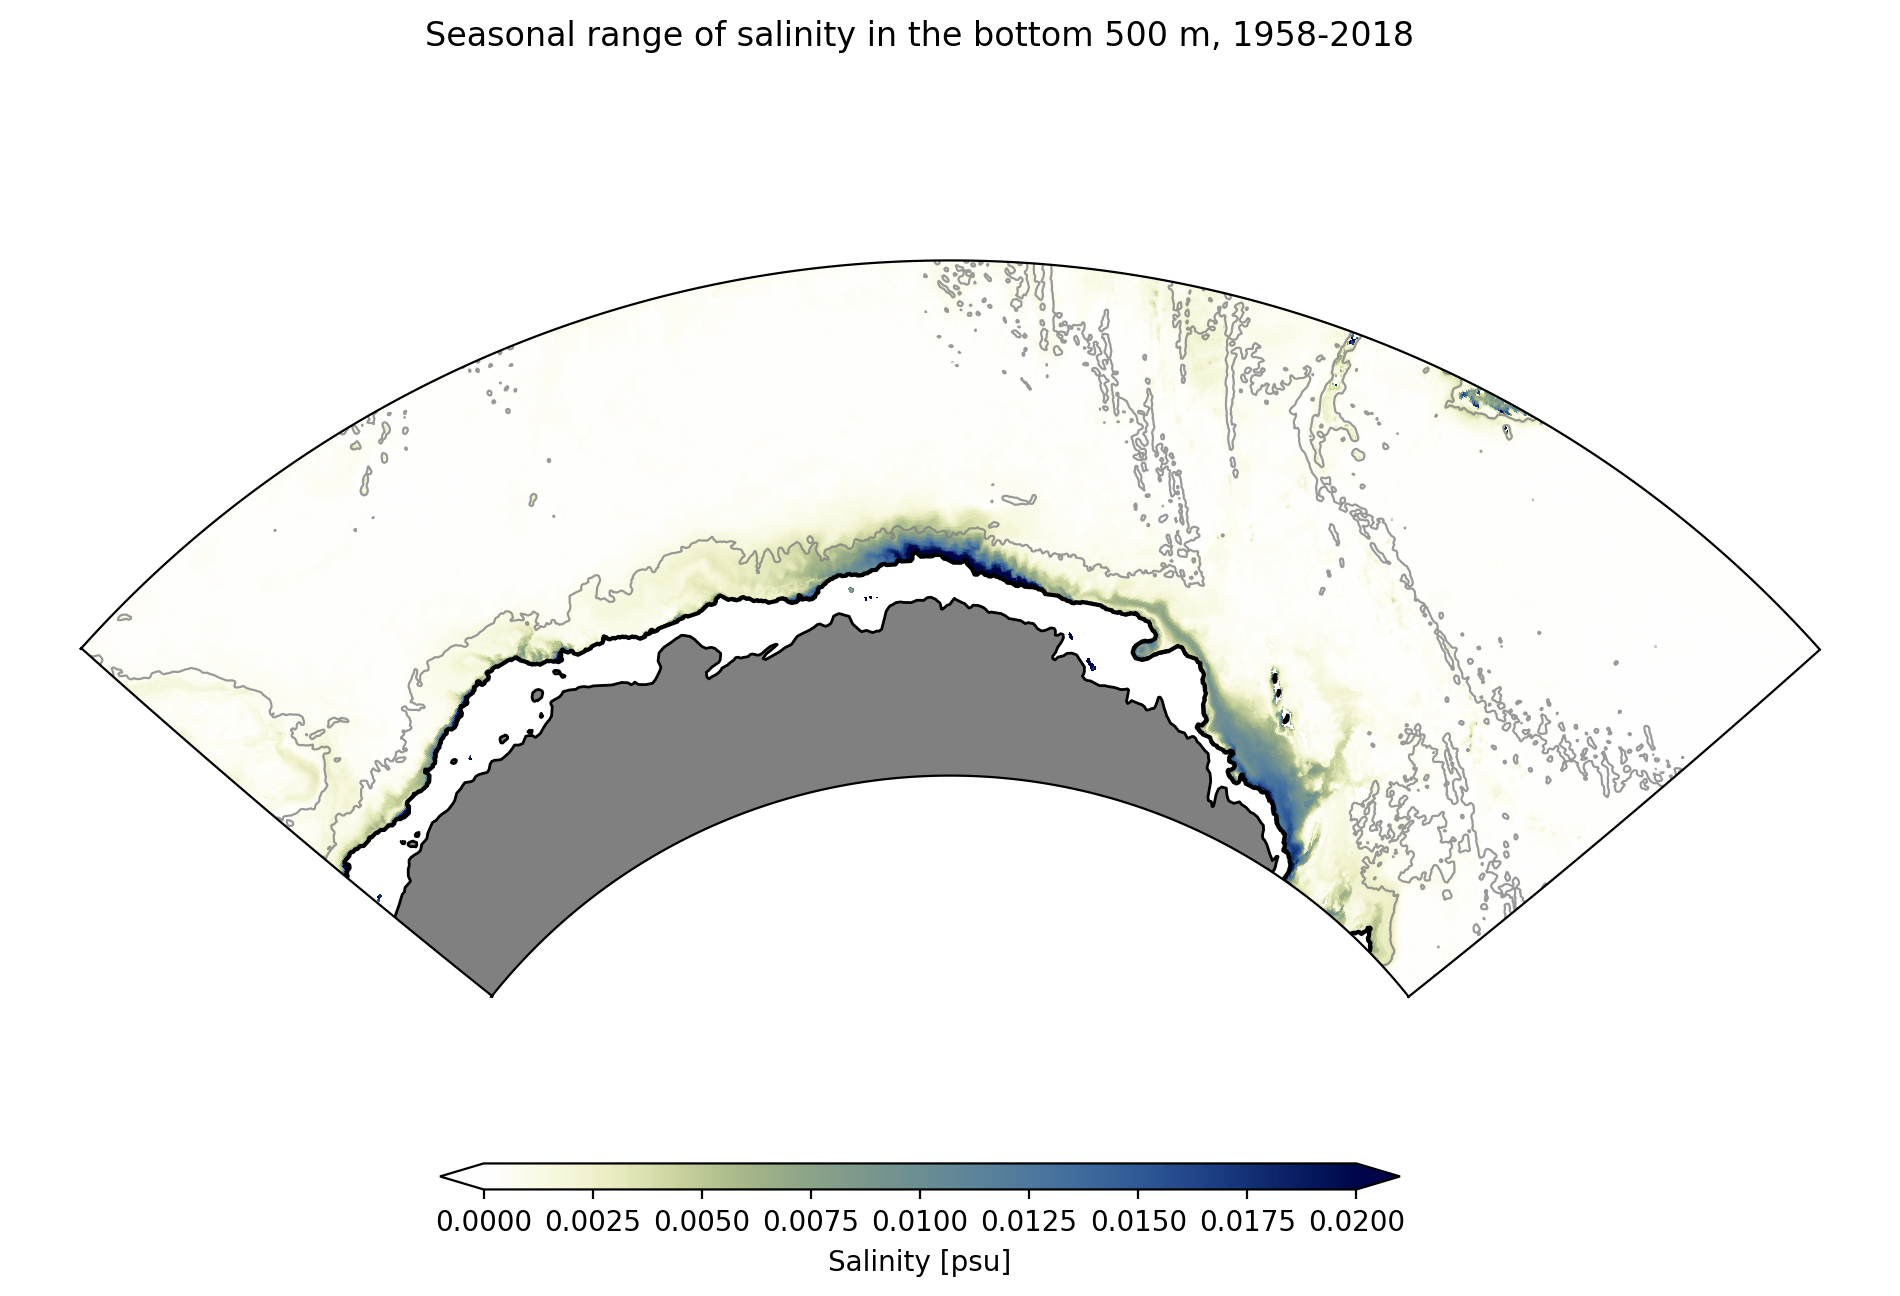

In [20]:
midlon = -225
maxlon = midlon + 60
minlon = midlon - 60
minlat = -72
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
plt.suptitle('Salinity range')
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

# To plot 1000-m contour
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf[np.where(shelf!=0)] = np.nan
shelf = shelf+1
shelf = np.nan_to_num(shelf)
shelf = xr.DataArray(shelf, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])


ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.01, vmax=0.02)
cmap = cmcrameri.cm.davos_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, salt_range, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('Salinity [psu]')
plt.suptitle(f'Seasonal range of salinity in the bottom 500 m, {first_year}-{last_year}')


plt.savefig(f'{figdir}/bottom_salinity_range_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


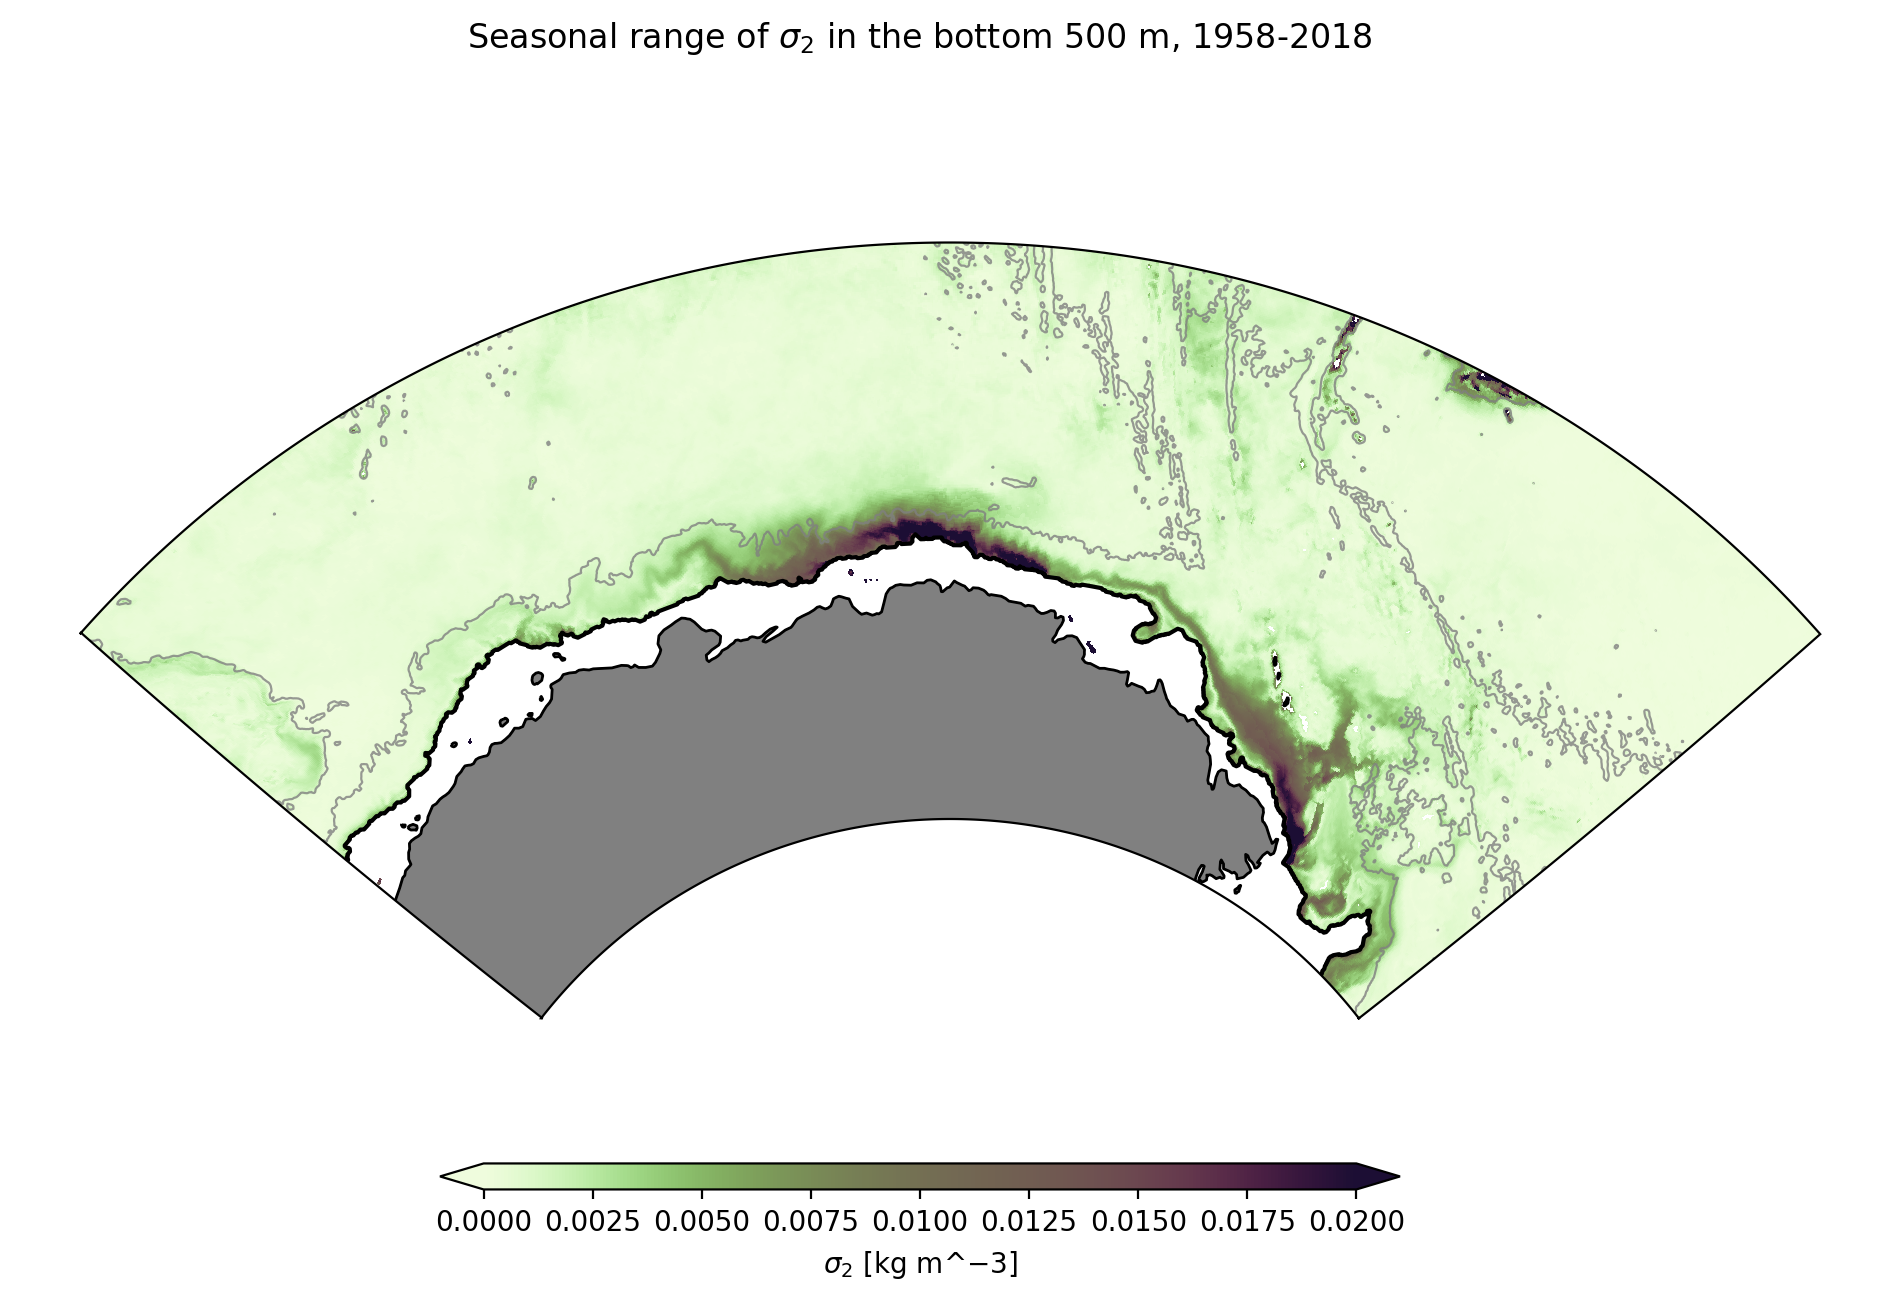

In [27]:
midlon = -225
maxlon = midlon + 60
minlon = midlon - 60
minlat = -74
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
plt.suptitle('Density seasonal range')
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

# To plot 1000-m contour
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf[np.where(shelf!=0)] = np.nan
shelf = shelf+1
shelf = np.nan_to_num(shelf)
shelf = xr.DataArray(shelf, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])


ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.01, vmax=0.02)
cmap = cmcrameri.cm.tokyo_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, sigma2_range, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('$\sigma_2$ [kg m^${-3}$]')
plt.suptitle(f'Seasonal range of $\sigma_2$ in the bottom 500 m, {first_year}-{last_year}')


plt.savefig(f'{figdir}/sigma_2_range_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')


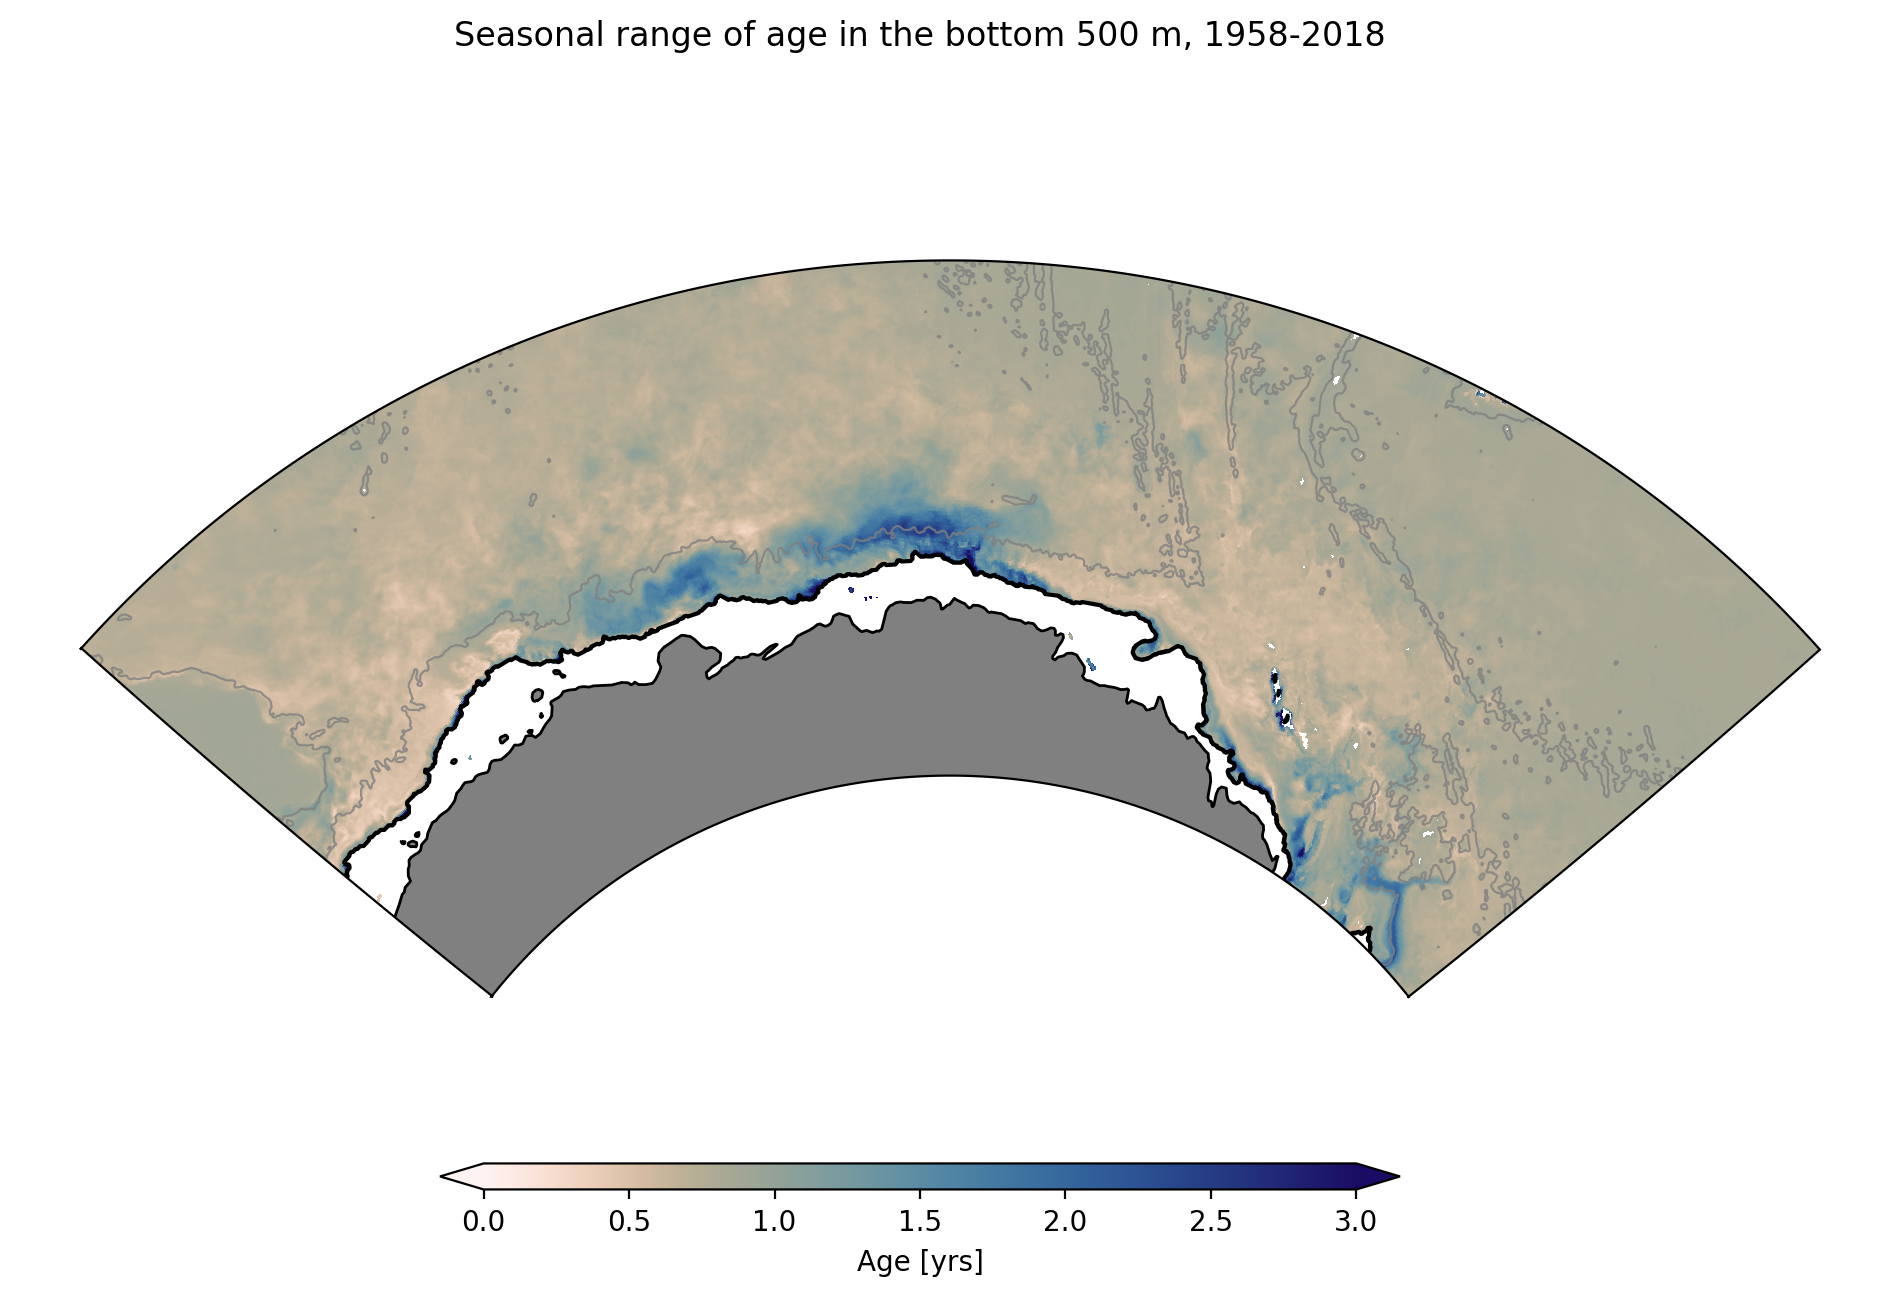

In [24]:
midlon = -225
maxlon = midlon + 60
minlon = midlon - 60
minlat = -72
maxlat = -55
midlat = (minlat + maxlat) / 2

projection = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
plt.suptitle('Age range')
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution="50m")
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


lons = X.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)
lats = Y.sel(
    {"xt_ocean": slice(minlon, maxlon), "yt_ocean": slice(minlat, maxlat)}
)

boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

# To plot 1000-m contour
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf[np.where(shelf!=0)] = np.nan
shelf = shelf+1
shelf = np.nan_to_num(shelf)
shelf = xr.DataArray(shelf, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])


ax.contour(shelf.xt_ocean, shelf.yt_ocean,shelf,
                [0.5],
                colors = 'k',
                linewidths = 1.5,
                transform=ccrs.PlateCarree())

ax.contour(ht.xt_ocean, ht.yt_ocean, ht,
                levels=[3500],
                colors='grey',
                linewidths=.8,
                alpha=.8,
                transform=ccrs.PlateCarree())

norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=1.5, vmax=3)
cmap = cmcrameri.cm.lapaz_r
pc = plt.pcolormesh(ht.xt_ocean+360, ht.yt_ocean, age_range, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('Age [yrs]')
plt.suptitle(f'Seasonal range of age in the bottom 500 m, {first_year}-{last_year}')


plt.savefig(f'{figdir}/bottom_age_range_{first_year}-{last_year}.png', dpi=250, bbox_inches='tight')
